# CS 4993 Independent Study – Machine Learning with COVID Data

***Professor: [Haiyang Shen](https://engineering.virginia.edu/faculty/haiying-shen)***  
***Researcher: [Iain Muir](https://www.linkedin.com/in/iain-muir-b37718164/) | iam9ez***

*Github Project:* https://github.com/iainmuir6/machineLearning_covidData  
*Last Updated: June 15th, 2021*  

*References*
* [CS 4774 ML Material – Professor Rich Nguyen](https://www.cs.virginia.edu/~nn4pj/teaching)
* [Steps to Building Machine Learning Model](https://analyticsindiamag.com/the-7-key-steps-to-build-your-machine-learning-model/)
* [Steps to Data Preprocessing](https://hackernoon.com/what-steps-should-one-take-while-doing-data-preprocessing-502c993e1caa)
* [Handling Missing Values](https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e)
* [Feature Selection I](https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2)
* [Feature Selection II](https://machinelearningmastery.com/feature-selection-machine-learning-python/)
* [Keras Neural Network I](https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3)
* [GAN Github Repository – codyznash](https://github.com/codyznash/GANs_for_Credit_Card_Data/blob/7f7e2dfb6ab15eb0d520fa6611fe03d6f8646141/GAN_171103.py#L47)
* [GAN I](https://datasciencecampus.ons.gov.uk/projects/generative-adversarial-networks-gans-for-synthetic-dataset-generation-with-binary-classes/)
* [GAN II](https://nbviewer.jupyter.org/github/codyznash/GANs_for_Credit_Card_Data/blob/master/GAN_comparisons.ipynb#Generated%20Data%20Testing)

## Table of Contents <a class="anchor" id="toc"></a>
* **[0. Import Packages](#setup)**
    * [0.1 General Imports](#imp1)
    * [0.2 ML Imports](#imp2)
* **[1. Read Excel File](#data)**
    * [1.1 Data Overview](#overview)
    * [1.2 Descriptive Statistics](#stats)
    * [1.3 Inspect Null Data](#null)
* **[2. Data Preparation](#prep)**
    * [2.1 Drop Columns](#drop)
    * [2.2 Handle Categorical Variables](#handle1)
        * *[2.2.1 Manual Conversion](#manual)*
        * *[2.2.2 Encoding](#encoding)*
        * *[2.2.3 Categorical Codes](#codes)*
    * [2.3 Handle Missing Values](#handle2)
    * [2.4 Feature Scaling](#scaling)
    * [2.5 Train / Test Split](#split)
    * [2.6 Final Prepared Data](#final_data)
* **[3. Feature Selection I](#feature)**
    * [3.1 Pearson Correlation](#corr)
    * [3.2 Chi-Squared Test](#chi_sq)
    * [3.3 Recursive Feature Elimination](#rfe)
    * [3.4 SelectFromModel: Lasso](#lasso)
    * [3.5 SelectFromModel: Random Forest Classifier](#rfc)
    * [3.6 Cumulative Feature Selection](#cum)
* **[4. Model Selection](#model)**
    * [4.1 Train / Test Data](#tt)
    * [4.2 Model Evaluation Functions](#funcs)
    * [4.3 Model Construction](#models)
        * *[4.3.1 Decision Tree](#dt)*
        * *[4.3.2 Random Forest Classifier](#rfc2)*
        * *[4.3.3 K-Nearest Neighbors Classifier](#knn)*
        * *[4.3.4 Deep Neural Network](#dnn)*
        * *[4.3.5 Convolutional Neural Network](#cnn)*
        * *[4.3.6 Recurrent Neural Network](#rnn)*
    * [4.4 Simultaneous Model Evaluation](#eval)
    * [4.5 RandomizedSearch](#search)
* **[5. Generative Adverserial Networks](#gan)**
    * [5.1 Network Setup](#setup2)
    * [5.2 Training GAN Models](#train)
        * [5.2.1 GAN](#gan2)
        * [5.2.2 CGAN](#cgan)
        * [5.2.3 WGAN + WCGAN](#wgan)
    * [5.3 Loss Information](#loss)
    * [5.4 Generate New Data](#new_data)
    * [5.5 Training Models on New Data](#train_gan)
    * [5.6 Plot Real vs Test Data](#plot)
    * [5.7 Feature Importance](#importance)
* **[6. Retrain Models with GAN Data](#retrain)**
    * [6.1 Re-Prepare Data](#prep2)
    * [6.2 Re-Train Models](#retrain2)
* **[7. Final Model Training with Feature Selection](#final)**
    * [7.1 Define Models and Variables](#define)
    * [7.2 Model Performance w/o GAN](#perf1)
    * [7.3 Model Performance with GAN](#perf2)

## 0. Import Packages <a class="anchor" id="setup"></a>

[Table of Contents](#toc)

#### 0.1 General Imports <a class="anchor" id="imp1"></a>

In [1]:
from IPython.display import Markdown, Image, display
from scipy.stats import reciprocal
import matplotlib.pyplot as plt
from matplotlib import cm
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import random
import os

#### 0.2 ML Imports <a class="anchor" id="imp2"></a>

In [266]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals.six import StringIO
import pydotplus
import sklearn

from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, Embedding, SimpleRNN, LSTM, GRU
from keras.layers import LeakyReLU, PReLU, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import tensorflow.compat.v1 as tf
from tensorflow import keras
tf.disable_v2_behavior()

import xgboost as xgb
from GAN import GAN

In [3]:
tf.__version__

'2.3.0'

In [4]:
keras.__version__

'2.4.0'

In [5]:
sklearn.__version__

'0.21.2'

In [6]:
SEED = 0

## 1. Read Excel File <a class="anchor" id="data"></a>

[Table of Contents](#toc)

#### 1.1 Data Overview <a class="anchor" id="overview"></a>

In [7]:
df = pd.read_excel('ed_pred.xlsx')
df = df.reset_index()
df.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2


In [8]:
df.shape

(7380, 41)

In [9]:
target = 'COVIDResult'
df.columns

Index(['index', 'patno', 'Admitted', 'AdmittingDepartment', 'COVIDResult',
       'Age', 'FirstRace', 'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp',
       'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit',
       'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c',
       'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc',
       'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c',
       'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose',
       'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein',
       'cmp_albumin', 'cmp_bilirubin'],
      dtype='object')

###### Column Description
Note (src - [Walk-In-Lab](https://www.walkinlab.com/products/view/complete-blood-count-cbc-comprehensive-metabolic-panel-cmp-14-blood-test-panel#:~:text=A%20CBC%20also%20helps%20your,anemia%2C%20and%20several%20other%20disorders.&text=Comprehensive%20Metabolic%20Panel%20)): 

CBC == [Complete Blood Count](https://www.mayoclinic.org/tests-procedures/complete-blood-count/about/pac-20384919)
* Complete Blood Count (CBC) gives important information about the numbers and kinds of cells in the blood, especially red blood cells, white blood cells, and platelets. A CBC helps your health professional check any symptoms, such as fatigue, weakness, or bruising, that you may have. A CBC also helps your health professional diagnose conditions, such as infection, anemia, and several other disorders.

CMP == [Comprehensive Metabolic Panel](https://www.mayocliniclabs.com/test-catalog/Clinical+and+Interpretive/113631)
* Comprehensive Metabolic Panel (CMP-14) with eGFR is a group of 14 laboratory tests ordered to give information about the current status of your liver, kidneys, and electrolyte and acid/base balance.  The test gives the current status of your blood sugar and blood proteins also.

#### 1.2 Descriptive Statistics <a class="anchor" id="stats"></a>

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7380 non-null   int64  
 1   patno                     7380 non-null   int64  
 2   Admitted                  7380 non-null   int64  
 3   AdmittingDepartment       3003 non-null   object 
 4   COVIDResult               7380 non-null   object 
 5   Age                       7380 non-null   int64  
 6   FirstRace                 7379 non-null   object 
 7   Ethnicity                 7380 non-null   object 
 8   Sex                       7380 non-null   object 
 9   heart_rate                7352 non-null   float64
 10  sbp                       7292 non-null   float64
 11  dbp                       7292 non-null   float64
 12  pulse_ox                  7346 non-null   float64
 13  resp_rate                 7312 non-null   float64
 14  height  

In [11]:
df.describe()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
count,7380.000000,7380.000000,7380.000000,7380.000000,7352.000000,7292.000000,7292.000000,7346.000000,7312.000000,456.000000,...,3874.000000,3872.000000,6286.000000,5570.000000,6286.000000,6286.000000,4767.000000,5399.000000,5175.000000,5402.000000
mean,3689.500000,3690.500000,0.406911,48.977642,94.529788,135.998354,76.034696,97.064661,21.029130,65.971491,...,0.740428,1.492485,137.104677,4.043447,102.562997,137.406141,55.627858,114.154843,7.210473,3.846113
std,2130.566826,2130.566826,0.491291,23.525661,23.352438,27.256409,15.302797,3.832935,6.762566,7.635750,...,0.545253,2.276703,4.366669,0.603037,5.600923,92.857337,154.142598,89.983238,0.843891,0.577974
min,0.000000,1.000000,0.000000,0.000000,0.000000,46.000000,0.000000,25.000000,0.000000,2.000000,...,0.000000,0.000000,107.000000,2.000000,60.000000,22.000000,7.000000,21.000000,2.400000,1.000000
25%,1844.750000,1845.750000,0.000000,31.000000,78.000000,118.000000,65.000000,96.000000,18.000000,63.000000,...,0.460000,0.100000,135.000000,3.700000,100.000000,94.000000,23.000000,71.000000,6.700000,3.500000
50%,3689.500000,3690.500000,0.000000,52.000000,92.000000,133.000000,75.000000,98.000000,20.000000,67.000000,...,0.670000,0.800000,138.000000,4.000000,103.000000,109.000000,31.000000,90.000000,7.200000,3.900000
75%,5534.250000,5535.250000,1.000000,67.000000,107.000000,151.000000,86.000000,99.000000,22.000000,70.000000,...,0.940000,2.000000,140.000000,4.300000,106.000000,140.000000,46.000000,123.000000,7.700000,4.200000
max,7379.000000,7380.000000,1.000000,119.000000,235.000000,258.000000,147.000000,100.000000,111.000000,77.000000,...,17.790000,41.100000,182.000000,8.900000,143.000000,1576.000000,6479.000000,1126.000000,11.300000,6.300000


In [12]:
df.corr()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
index,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
patno,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
Admitted,-0.030377,-0.030377,1.000000,0.259000,0.071533,-0.034520,-0.083964,-0.187805,0.141345,0.006556,...,0.090950,-0.122416,-0.139857,0.123330,-0.145144,0.125331,0.098732,0.117501,-0.169298,-0.301735
Age,-0.071132,-0.071132,0.259000,1.000000,-0.343054,0.255632,0.021500,-0.233759,-0.128765,0.237857,...,-0.068070,-0.003148,-0.077553,0.129890,-0.137116,0.097948,-0.014016,-0.091849,-0.147716,-0.312481
heart_rate,-0.014543,-0.014543,0.071533,-0.343054,1.000000,-0.128325,0.032385,-0.018398,0.397967,-0.277916,...,0.100502,-0.102094,-0.062122,-0.048065,-0.073826,0.074114,0.025044,0.123586,0.046071,0.021046
sbp,-0.013479,-0.013479,-0.034520,0.255632,-0.128325,1.000000,0.700990,0.012399,-0.054224,0.129512,...,-0.037211,0.056011,0.089829,-0.016583,0.003022,0.052785,-0.058817,-0.102502,0.195652,0.193473
dbp,-0.002088,-0.002088,-0.083964,0.021500,0.032385,0.700990,1.000000,0.044760,-0.038692,0.178501,...,-0.019228,0.026571,0.119920,-0.055991,0.036059,0.017755,-0.010922,-0.091883,0.268447,0.288271
pulse_ox,0.066634,0.066634,-0.187805,-0.233759,-0.018398,0.012399,0.044760,1.000000,-0.203094,0.003070,...,-0.002565,0.017027,0.012110,-0.118440,0.099202,-0.105208,-0.052456,-0.005379,0.037321,0.123265
resp_rate,-0.031710,-0.031710,0.141345,-0.128765,0.397967,-0.054224,-0.038692,-0.203094,1.000000,-0.339655,...,0.078115,-0.037053,-0.013692,0.118477,-0.008239,0.076232,0.037055,0.099776,-0.078270,-0.083926
height,-0.017314,-0.017314,0.006556,0.237857,-0.277916,0.129512,0.178501,0.003070,-0.339655,1.000000,...,-0.033168,-0.156211,0.055314,-0.173582,0.030194,0.057657,0.005574,-0.187236,0.127008,0.030490


In [13]:
# NOTE: Unbalanced Dataset - could lead to issues with DL model
print(df[target].value_counts())

None Detected    6910
Detected          470
Name: COVIDResult, dtype: int64


In [14]:
# NOTE: No Duplicates
none_detected_dups = sum(df.loc[df[target]=='None Detected'].duplicated())
detected_dups = sum(df.loc[df[target]=='Detected'].duplicated())
total_dups = none_detected_dups + detected_dups

print('None Detected Duplicates:', none_detected_dups)
print('Detected Duplicates:', detected_dups)
print('Total Duplicates:', total_dups)
print('Fraction Duplicated:', total_dups / len(df))

None Detected Duplicates: 0
Detected Duplicates: 0
Total Duplicates: 0
Fraction Duplicated: 0.0


#### 1.3 Inspect Null Data <a class="anchor" id="null"></a>

In [15]:
# NOTE: Evident that there are a lot of NULLs in the dataset
# Especially for variables height, AdmittingDepartment, wght
print('Total Number of NULL Data Points:', df.isnull().sum().sum())
df.isnull().sum()

Total Number of NULL Data Points: 69411


index                          0
patno                          0
Admitted                       0
AdmittingDepartment         4377
COVIDResult                    0
Age                            0
FirstRace                      1
Ethnicity                      0
Sex                            0
heart_rate                    28
sbp                           88
dbp                           88
pulse_ox                      34
resp_rate                     68
height                      6924
wght                        4132
cbc_wbc                     1124
cbc_hematocrit              1124
cbc_hemoglobin              1123
cbc_platelets               1124
cbc_neutrophil_c            3507
cbc_eosinophil_perc         3508
cbc_lymphocyte_c            3506
cbc_lymphocyte_perc         3506
cbc_eosinophil_c            3508
cbc_eosinophil_perc.1       3508
cbc_monocyte_c              3506
cbc_eosinophil_perc.2       3508
cmp_sodium                  1094
cmp_potassium               1810
cmp_chlori

In [16]:
# NOTE: Checking the % of NULLs for each variable in the dataset
d = {
    col: round(df[col].isnull().sum() * 100 / len(df[col]), 4)
    for col in df
}
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
majority_null = [k for k, v in d.items() if v > 50.0]

print("Null Data Points by variable")
d

Null Data Points by variable


{'height': 93.8211,
 'AdmittingDepartment': 59.3089,
 'wght': 55.9892,
 'cbc_eosinophil_perc': 47.5339,
 'cbc_eosinophil_c': 47.5339,
 'cbc_eosinophil_perc.1': 47.5339,
 'cbc_eosinophil_perc.2': 47.5339,
 'cbc_neutrophil_c': 47.5203,
 'cbc_lymphocyte_c': 47.5068,
 'cbc_lymphocyte_perc': 47.5068,
 'cbc_monocyte_c': 47.5068,
 'cmp_ast': 35.4065,
 'cmp_total_protein': 29.878,
 'cmp_alkaline_phosphatase': 26.8428,
 'cmp_alt': 26.8157,
 'cmp_bilirubin': 26.8157,
 'cmp_albumin': 26.8022,
 'cmp_potassium': 24.5257,
 'cbc_wbc': 15.2304,
 'cbc_hematocrit': 15.2304,
 'cbc_platelets': 15.2304,
 'cbc_hemoglobin': 15.2168,
 'cmp_bicarbonate': 14.9593,
 'cmp_sodium': 14.8238,
 'cmp_chloride': 14.8238,
 'cmp_bun': 14.8238,
 'cmp_creatinine': 14.8238,
 'cmp_glucose': 14.8238,
 'sbp': 1.1924,
 'dbp': 1.1924,
 'resp_rate': 0.9214,
 'pulse_ox': 0.4607,
 'heart_rate': 0.3794,
 'FirstRace': 0.0136,
 'index': 0.0,
 'patno': 0.0,
 'Admitted': 0.0,
 'COVIDResult': 0.0,
 'Age': 0.0,
 'Ethnicity': 0.0,
 'Sex': 

<AxesSubplot:>

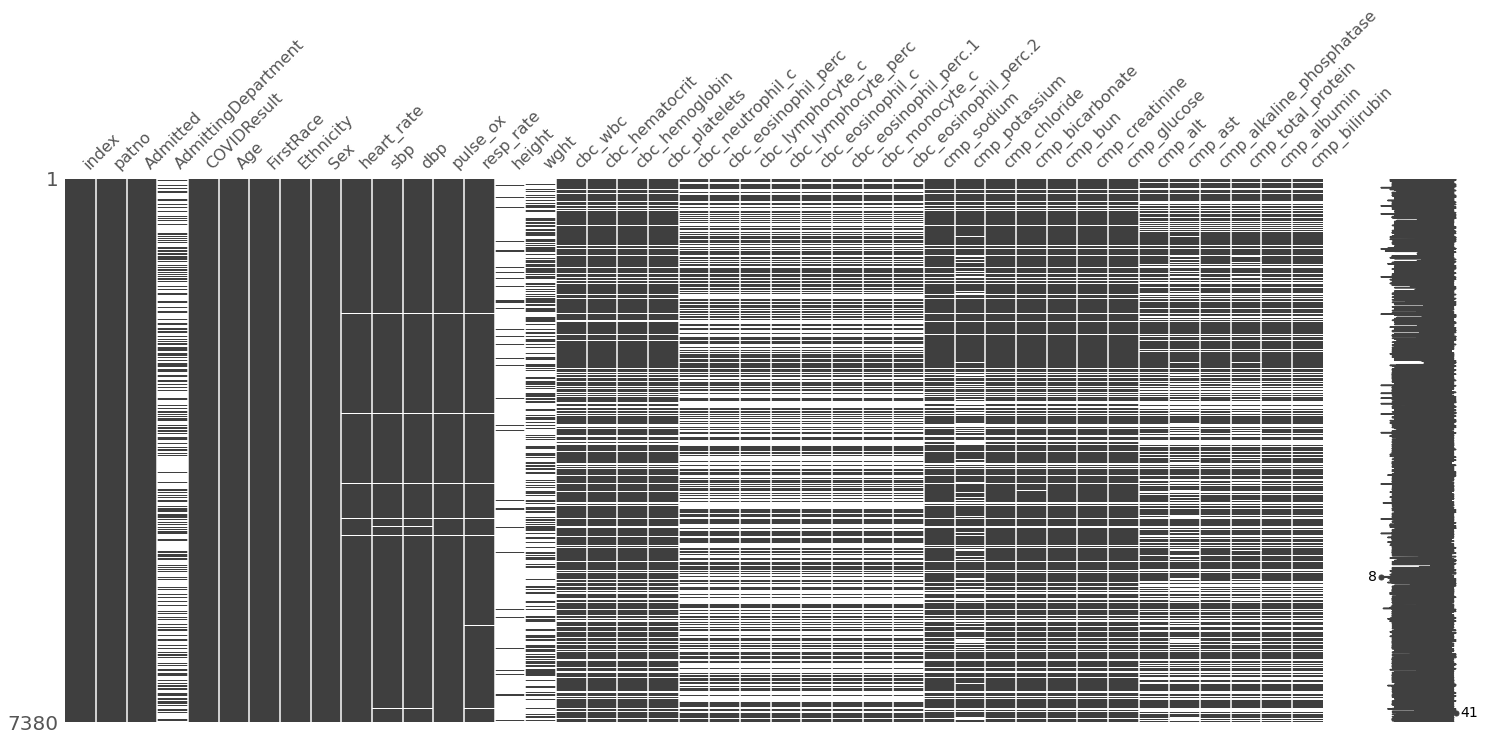

In [17]:
msno.matrix(df)
# msno.heatmap(df)

## 2. Data Preparation <a class="anchor" id="prep"></a>

[Table of Contents](#toc)

#### 2.1 Drop Columns <a class="anchor" id="drop"></a>

In [18]:
# NOTE: True indicates that columns with >50% NULL will be dropped
#       False indicates that no columns are dropped
drop = False

In [19]:
if drop:
    trim_df = df.drop(columns=majority_null)
    trim_df = trim_df.drop(columns=['index', 'patno'])
    trim_df.head(5)
else:
    trim_df = df

In [20]:
trim_df.isnull().sum().sum()

69411

#### 2.2 Handle Categorical Variables <a class="anchor" id="handle1"></a>

In [21]:
trim_df.select_dtypes(include=['object']).columns

Index(['AdmittingDepartment', 'COVIDResult', 'FirstRace', 'Ethnicity', 'Sex',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_alt',
       'cmp_bilirubin'],
      dtype='object')

###### 2.2.1 Manual Conversion <a class="anchor" id="manual"></a>

In [22]:
# NOTE: These five columns should be numeric, but certain < symbols make them categorical
#       Considering these data points are infrequent, I decided to replace them with a random number between 
#       zero and the upper range (Ex. <5 became a rand number between 0 and 5)
num_cat_cols = [
    'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_alt', 'cmp_bilirubin'
]
less_than_list = [
    '<5', '<2', '<0.2', '<6', '<0.1'
]


def replace_cat(val, less, num):
    if val == less:
        return random.uniform(0, num) if "." in less else random.randint(0, num)
    else:
        return float(val)

    
trim_df2 = trim_df.copy()
for col, less_than in zip(num_cat_cols, less_than_list):
    upper_range = float(less_than[1:])
    trim_df2[col] = trim_df2[col].apply(lambda x: replace_cat(x, less_than, upper_range))

trim_df2.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26.0,31.0,2.5,82.0,14.0,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19.0,11.0,0.9,83.0,73.0,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23.0,9.0,1.2,123.0,26.0,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30.0,45.0,1.6,297.0,22.0,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27.0,25.0,1.0,96.0,12.0,18.0,122.0,7.4,3.5,0.2


In [23]:
trim_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7380 non-null   int64  
 1   patno                     7380 non-null   int64  
 2   Admitted                  7380 non-null   int64  
 3   AdmittingDepartment       3003 non-null   object 
 4   COVIDResult               7380 non-null   object 
 5   Age                       7380 non-null   int64  
 6   FirstRace                 7379 non-null   object 
 7   Ethnicity                 7380 non-null   object 
 8   Sex                       7380 non-null   object 
 9   heart_rate                7352 non-null   float64
 10  sbp                       7292 non-null   float64
 11  dbp                       7292 non-null   float64
 12  pulse_ox                  7346 non-null   float64
 13  resp_rate                 7312 non-null   float64
 14  height  

###### 2.2.2 Encoding <a class="anchor" id="encoding"></a>

In [24]:
# NOTE: Convert all remaining categorical variables using Ordinal Encoding
cat_cols = list(trim_df2.select_dtypes(include=['object']).columns)

trim_df3 = trim_df2.copy()
trim_df3['FirstRace'] = trim_df3['FirstRace'].fillna("Unspecified")
if not drop:
    trim_df3['AdmittingDepartment'] = trim_df3['AdmittingDepartment'].fillna('N/A')
for col in cat_cols:
    enc = OrdinalEncoder()
    y = enc.fit_transform(trim_df3[[col]])
    if col == 'COVIDResult':
        y = 1 - y           # Switching code (standard for the 'normal' code to be 0)
    trim_df3[col + "_Encoded"] = y
trim_df3.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,AdmittingDepartment_Encoded,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26.0,80.0,8.5,4.3,0.5,30.0,0.0,9.0,2.0,0.0
1,1,2,0,N/A,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,NaN,100.0,8.1,4.6,0.6,1.0,0.0,9.0,2.0,0.0
2,2,3,0,N/A,None Detected,55,African American,Non-Hispanic,Male,83.0,...,29.0,106.0,7.1,4.0,0.7,1.0,0.0,0.0,2.0,1.0
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,NaN,78.0,7.8,3.7,0.5,30.0,0.0,9.0,2.0,1.0
4,4,5,0,N/A,None Detected,67,African American,Non-Hispanic,Female,90.0,...,18.0,122.0,7.4,3.5,0.2,1.0,0.0,0.0,2.0,0.0


###### 2.2.3 Categorical Codes <a class="anchor" id="codes"></a>

In [25]:
for col in cat_cols:
    if col == 'AdmittingDepartment':
        continue
    display(Markdown("**{}**".format(col)))
    for each in trim_df3.groupby([col, col + '_Encoded']).indices:
        print(each)
    print()

**COVIDResult**

('Detected', 1.0)
('None Detected', 0.0)



**FirstRace**

('African American', 0.0)
('American Indian and Alaska Native', 1.0)
('Asian', 2.0)
('Hispanic', 3.0)
('Native Hawaiian and Other Pacific Islander', 4.0)
('Other', 5.0)
('Patient Refused', 6.0)
('Patient Unavailable', 7.0)
('Unspecified', 8.0)
('White or Caucasian', 9.0)



**Ethnicity**

('*Unspecified', 0.0)
('Hispanic', 1.0)
('Non-Hispanic', 2.0)
('Patient Refused', 3.0)
('Patient Unavailable', 4.0)



**Sex**

('Female', 0.0)
('Male', 1.0)
('Unknown', 2.0)



In [26]:
trim_df3 = trim_df3.drop(columns=cat_cols)
trim_df3.head(5)

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,AdmittingDepartment_Encoded,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,1,1,78,94.0,138.0,82.0,96.0,29.0,NaN,...,26.0,80.0,8.5,4.3,0.5,30.0,0.0,9.0,2.0,0.0
1,1,2,0,23,121.0,134.0,88.0,98.0,18.0,NaN,...,NaN,100.0,8.1,4.6,0.6,1.0,0.0,9.0,2.0,0.0
2,2,3,0,55,83.0,152.0,76.0,98.0,21.0,NaN,...,29.0,106.0,7.1,4.0,0.7,1.0,0.0,0.0,2.0,1.0
3,3,4,1,50,88.0,138.0,65.0,87.0,18.0,NaN,...,NaN,78.0,7.8,3.7,0.5,30.0,0.0,9.0,2.0,1.0
4,4,5,0,67,90.0,128.0,69.0,98.0,18.0,NaN,...,18.0,122.0,7.4,3.5,0.2,1.0,0.0,0.0,2.0,0.0


In [27]:
trim_df3.shape

(7380, 41)

In [28]:
trim_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        7380 non-null   int64  
 1   patno                        7380 non-null   int64  
 2   Admitted                     7380 non-null   int64  
 3   Age                          7380 non-null   int64  
 4   heart_rate                   7352 non-null   float64
 5   sbp                          7292 non-null   float64
 6   dbp                          7292 non-null   float64
 7   pulse_ox                     7346 non-null   float64
 8   resp_rate                    7312 non-null   float64
 9   height                       456 non-null    float64
 10  wght                         3248 non-null   float64
 11  cbc_wbc                      6256 non-null   float64
 12  cbc_hematocrit               6256 non-null   float64
 13  cbc_hemoglobin    

#### 2.3 Handle Missing Values <a class="anchor" id="handle2"></a>

In [29]:
# NOTE: A indicates that remaining NULLs will be replaced with 0
#       B/Other indicates that remaining NULLs will be replaced with the column's mean value
#       Option A will be the default to avoid changing the dataset too much
fill_option = 'A'

In [30]:
num_cols = list(trim_df2.select_dtypes(include=['float64']).columns)

trim_df4 = trim_df3.copy()
for col in num_cols:
    if fill_option == 'A':
        trim_df4[col] = trim_df4[col].fillna(0)
    else:
        trim_df4[col] = trim_df4[col].replace(np.NaN, trim_df4[col].mean())
    
trim_df4.head(5)

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,AdmittingDepartment_Encoded,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,1,1,78,94.0,138.0,82.0,96.0,29.0,0.0,...,26.0,80.0,8.5,4.3,0.5,30.0,0.0,9.0,2.0,0.0
1,1,2,0,23,121.0,134.0,88.0,98.0,18.0,0.0,...,0.0,100.0,8.1,4.6,0.6,1.0,0.0,9.0,2.0,0.0
2,2,3,0,55,83.0,152.0,76.0,98.0,21.0,0.0,...,29.0,106.0,7.1,4.0,0.7,1.0,0.0,0.0,2.0,1.0
3,3,4,1,50,88.0,138.0,65.0,87.0,18.0,0.0,...,0.0,78.0,7.8,3.7,0.5,30.0,0.0,9.0,2.0,1.0
4,4,5,0,67,90.0,128.0,69.0,98.0,18.0,0.0,...,18.0,122.0,7.4,3.5,0.2,1.0,0.0,0.0,2.0,0.0


In [31]:
trim_df3.isnull().sum().sum()

65033

In [32]:
trim_df4.isnull().sum().sum()

0

#### 2.4 Feature Scaling <a class="anchor" id="scaling"></a>

In [33]:
code_cols = [
    'Admitted', 'FirstRace_Encoded', 'Ethnicity_Encoded', 'Sex_Encoded',
    'AdmittingDepartment_Encoded', 'COVIDResult_Encoded'
]

# NOTE: This column would not exist if drop is True
if drop:
    code_cols.remove('AdmittingDepartment_Encoded')

codes_df = trim_df4[code_cols]
trim_df5 = trim_df4.drop(columns=code_cols)

scaler = StandardScaler()
scaled = scaler.fit_transform(trim_df5)
scaled_df = pd.DataFrame(data=scaled, columns=trim_df5.columns)

In [34]:
merged_df = pd.concat([scaled_df, codes_df], axis=1)
merged_df.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded
0,-1.731816,-1.731816,1.233730,-0.007125,0.117440,0.397106,-0.081200,1.162329,-0.254819,-0.760847,...,-0.038140,1.020349,0.837005,-0.077871,1,9.0,2.0,0.0,30.0,0.0
1,-1.731347,-1.731347,-1.104301,1.116931,-0.012210,0.743825,0.181805,-0.403647,-0.254819,-0.760847,...,0.179028,0.901837,1.006128,-0.012043,0,9.0,2.0,0.0,1.0,0.0
2,-1.730877,-1.730877,0.256008,-0.465074,0.571215,0.050387,0.181805,0.023438,-0.254819,1.151812,...,0.244178,0.605558,0.667883,0.053784,0,0.0,2.0,1.0,1.0,0.0
3,-1.730408,-1.730408,0.043460,-0.256915,0.117440,-0.585264,-1.264722,-0.403647,-0.254819,-0.760847,...,-0.059856,0.812953,0.498760,-0.077871,1,9.0,2.0,1.0,30.0,0.0
4,-1.729939,-1.729939,0.766124,-0.173652,-0.206684,-0.354118,0.181805,-0.403647,-0.254819,-0.760847,...,0.417912,0.694442,0.386011,-0.275352,0,0.0,2.0,0.0,1.0,0.0


#### 2.5 Train / Test Split <a class="anchor" id="split"></a>

In [35]:
train, test = train_test_split(merged_df, test_size=0.2, random_state=SEED)

#### 2.6 Final Prepared Data <a class="anchor" id="final_data"></a>

In [36]:
final_data = merged_df.copy()
final_train = train.copy()
final_test = test.copy()
target = 'COVIDResult_Encoded'

In [37]:
final_data.shape

(7380, 41)

In [38]:
final_train.shape

(5904, 41)

In [39]:
final_test.shape

(1476, 41)

In [40]:
print(final_train[target].value_counts())
print(final_test[target].value_counts())

0.0    5526
1.0     378
Name: COVIDResult_Encoded, dtype: int64
0.0    1384
1.0      92
Name: COVIDResult_Encoded, dtype: int64


## 3. Feature Selection <a class="anchor" id="feature"></a>

[Table of Contents](#toc)

In [41]:
X = final_data.loc[:, final_data.columns != target]
pos_X = trim_df4.loc[:, trim_df4.columns != target]
X_norm = MinMaxScaler().fit_transform(pos_X)
Y = final_data[target]

###### Number of Features

In [42]:
# NOTE: Set to be the length of columns to avoid removing features until the final model training
top_n_feats = len(X.columns)
# top_n_feats = 10

In [43]:
def plot_scores(scores, selector):
    plt.bar(range(len(scores)), scores, color='b')
    plt.show()

#### 3.1 Pearson Correlation <a class="anchor" id="corr"></a>

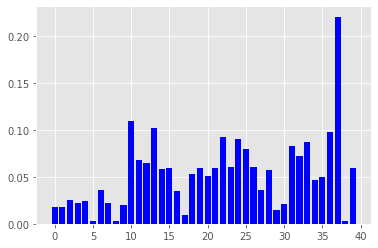

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [44]:
def correlation_selector(x, y):
    correl_dict = {
        col: np.corrcoef(x[col], y)[0, 1] for col in x.columns.tolist()
    }
    correl_dict = {
        col: 0 if np.isnan(cor) else np.abs(cor) for col, cor in correl_dict.items()
    }
    plot_scores(list(correl_dict.values()), 'correlation')
    
    correl_dict = dict(sorted(correl_dict.items(), key=lambda item: item[1], reverse=True)[:top_n_feats])
    top_n = np.array([
        True if col in list(correl_dict.keys()) else False for col in x.columns.tolist()
    ])
    return top_n


corr_top_n = correlation_selector(X, Y)
corr_top_n

#### 3.2 Chi-Squared <a class="anchor" id="chi_sq"></a>

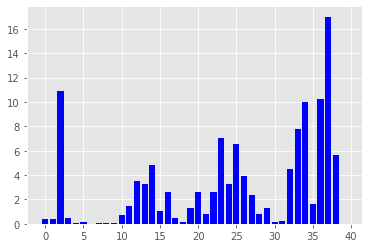

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [45]:
def chi_selector(y):
    chi_sq = SelectKBest(chi2, k=top_n_feats)
    chi_sq.fit(X_norm, y)
    top_n = chi_sq.get_support()
    plot_scores(chi_sq.scores_, 'chi-squared')
    return top_n


chi_top_n = chi_selector(Y)
chi_top_n

#### 3.3 Recursive Feature Elimination <a class="anchor" id="rfe"></a>

In [46]:
def rfe_selector(y):
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=top_n_feats, step=10, verbose=0)
    rfe.fit(X_norm, y)
    top_n = rfe.get_support()
    return top_n


rfe_top_n = rfe_selector(Y)
rfe_top_n

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

#### 3.4 Lasso: SelectFromModel <a class="anchor" id="lasso"></a>

In [47]:
def lasso_selector(y):
    lasso = SelectFromModel(LogisticRegression(penalty="l2"), max_features=top_n_feats)
    lasso.fit(X_norm, y)
    top_n = lasso.get_support()
    return top_n


lasso_top_n = lasso_selector(Y)
lasso_top_n

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([False, False, False,  True, False, False, False, False, False,
       False, False,  True, False,  True,  True, False,  True,  True,
        True, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True,
       False,  True,  True, False])

#### 3.5 RandomForestClassifier: SelectFromModel <a class="anchor" id="rfc"></a>

In [48]:
def rfc_selector(x, y):
    rfc = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=top_n_feats)
    rfc.fit(x, y)
    top_n = rfc.get_support()
    return top_n


rfc_top_n = rfc_selector(X, Y)
rfc_top_n

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False,  True])

#### 3.6 Cumulative Feature Selection <a class="anchor" id="cum"></a>

In [49]:
cumm_df = pd.DataFrame({
    'feature': X.columns.tolist(),
    'correlation': corr_top_n,
    'chi-sq': chi_top_n,
    'rfe': rfe_top_n,
    'lasso': lasso_top_n,
    'rfc': rfc_top_n
})
cumm_df['total'] = np.sum(cumm_df, axis=1)
cumm_df = cumm_df.sort_values(['total', 'feature'], ascending=False)
cumm_df.index = range(1, len(cumm_df) + 1)
cumm_df

,feature,correlation,chi-sq,rfe,lasso,rfc,total
1,heart_rate,True,True,True,True,True,5
2,cbc_platelets,True,True,True,True,True,5
3,cbc_hematocrit,True,True,True,True,True,5
4,Ethnicity_Encoded,True,True,True,True,True,5
5,wght,True,True,True,False,True,4
6,sbp,True,True,True,False,True,4
7,resp_rate,True,True,True,False,True,4
8,pulse_ox,True,True,True,False,True,4
9,patno,True,True,True,False,True,4
10,index,True,True,True,False,True,4


In [50]:
top_n_features = list(cumm_df.iloc[:top_n_feats]['feature'])
top_n_features

['heart_rate',
 'cbc_platelets',
 'cbc_hematocrit',
 'Ethnicity_Encoded',
 'wght',
 'sbp',
 'resp_rate',
 'pulse_ox',
 'patno',
 'index',
 'dbp',
 'cmp_total_protein',
 'cmp_sodium',
 'cmp_bilirubin',
 'cbc_wbc',
 'cbc_neutrophil_c',
 'cbc_monocyte_c',
 'cbc_lymphocyte_perc',
 'cbc_lymphocyte_c',
 'cbc_eosinophil_c',
 'Sex_Encoded',
 'FirstRace_Encoded',
 'Age',
 'AdmittingDepartment_Encoded',
 'Admitted',
 'height',
 'cmp_potassium',
 'cmp_glucose',
 'cmp_creatinine',
 'cmp_chloride',
 'cmp_bun',
 'cmp_bicarbonate',
 'cmp_ast',
 'cmp_alt',
 'cmp_alkaline_phosphatase',
 'cmp_albumin',
 'cbc_hemoglobin',
 'cbc_eosinophil_perc.2',
 'cbc_eosinophil_perc.1',
 'cbc_eosinophil_perc']

## 4. Model Selection <a class="anchor" id="model"></a>

[Table of Contents](#toc)

#### 4.1 Train / Test Data <a class="anchor" id="tt"></a>

In [51]:
X_train = final_train[top_n_features]
y_train = final_train[target]
X_test = final_test[top_n_features]
y_test = final_test[target]

In [52]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print()
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (5904, 40)
y_train (5904,)

X_test (1476, 40)
y_test (1476,)


#### 4.2 Model Evaluation Functions <a class="anchor" id="funcs"></a>

In [53]:
def plot_metric(hist, metric):
    train_metrics = hist.history[metric]
    val_metrics = hist.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and Validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [54]:
def plot_history(hist):
    display(Markdown('**Training/Validation Loss and Accuracy**'))
    pd.DataFrame(hist.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [55]:
def metric_evaluation(y_test, y_pred, labels=True):
    if labels:
        display(Markdown('**Metric Scores**'))
    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("Precision: {:.2f}%".format(precision_score(y_test, y_pred) * 100))
    print("Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))
    print("F1: {:.2f}%".format(f1_score(y_test, y_pred) * 100))
    if labels:
        display(Markdown('**Confusion Matrix**'))
    print(confusion_matrix(y_test, y_pred))

In [56]:
def plot_confusion_matrix(y_test, y_pred, labels=['None Detected', 'Detected']):
    cm_df = pd.DataFrame(
        confusion_matrix(y_test, y_pred), columns=labels, index=labels
    )
    ax = sns.heatmap(
        data=cm_df, cmap=cm.Blues, annot=True, fmt='d'
    )
    ax.set(xlabel='Predicted', ylabel='Actual')
    plt.show()

In [308]:
EPOCHS = 10
BATCH_SIZE = 200
VAL_SPLIT = 0.2

In [310]:
def test_models(models, xy, isolate=None):
    X_train, y_train, X_test, y_test = xy
    
    for i, m in enumerate(models):
        X_train_arr = np.array(X_train.values.tolist())
        y_train_arr = np.array(y_train)
        X_test_arr = np.array(X_test.values.tolist())
        y_test_arr = np.array(y_test)
        name, model, loss, optimizer, binary, dimensions = m.values()
        
        if isolate is not None and i + 1 != isolate:
            print('Skipping Model {}...'.format(i + 1))
            continue
        
        display(Markdown('### Model {} – {}'.format(i + 1, name)))
        
        # 1. Compile
        model.compile(
            loss=loss, optimizer=optimizer, metrics=['accuracy']
        )
        
        # 2. Fit
        shape = X_train_arr.shape
        if dimensions == 3:
            X_train_arr = X_train_arr.reshape(shape[0], shape[1], 1)
        elif dimensions == 4:
            X_train_arr = X_train_arr.reshape(shape[0], shape[1], 1, 1)
        
        history = model.fit(
            X_train_arr, y_train_arr,
            batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT, shuffle=True, verbose=0
        )
        
        # 3. Visualize Model
        display(Markdown("**Summary**"))
        model.summary()
        plot_history(history)
        
        # 4. Evaluate
        shape = X_test_arr.shape
        if dimensions == 3:
            X_test_arr = X_test_arr.reshape(shape[0], shape[1], 1)
        elif dimensions == 4:
            X_test_arr = X_test_arr.reshape(shape[0], shape[1], 1, 1)
            
        display(Markdown("**Evaluation and Prediction**"))
        loss, accuracy = model.evaluate(x=X_test_arr, y=y_test_arr)
        print("\nLoss: {:.2f}%".format(loss * 100))
        print("Accuracy: {:.2f}%".format(accuracy * 100))

        # 5. Predict
        y_prediction_array = model.predict(X_test_arr)
        
        if not binary:
            y_prediction = np.argmax(y_prediction_array, axis=1)
        else:
            y_prediction = np.round(y_prediction_array)
        
        # 6. Visualize Predictions
        metric_evaluation(y_test_arr, y_prediction)
        plot_confusion_matrix(y_test_arr, y_prediction)
        
        print()

#### 4.3 Model Construction <a class="anchor" id="models"></a>

In [59]:
tf.keras.backend.set_floatx('float64')
tf.set_random_seed(SEED)
np.random.seed(SEED)

###### 4.3.1 Decision Trees <a class="anchor" id="dt"></a>

**Metric Scores**

Accuracy: 94.11%
Precision: 100.00%
Recall: 5.43%
F1: 10.31%


**Confusion Matrix**

[[1384    0]
 [  87    5]]


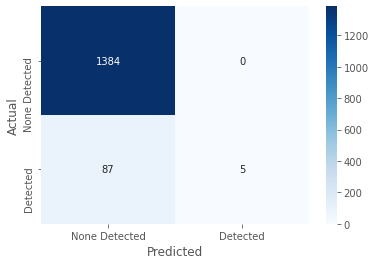

In [60]:
dt = DecisionTreeClassifier(
    max_depth=4, criterion="entropy", random_state=SEED
)
dt = dt.fit(X_train, y_train)
y_prediction = dt.predict(X_test)
metric_evaluation(y_test, y_prediction)
plot_confusion_matrix(y_test, y_prediction)

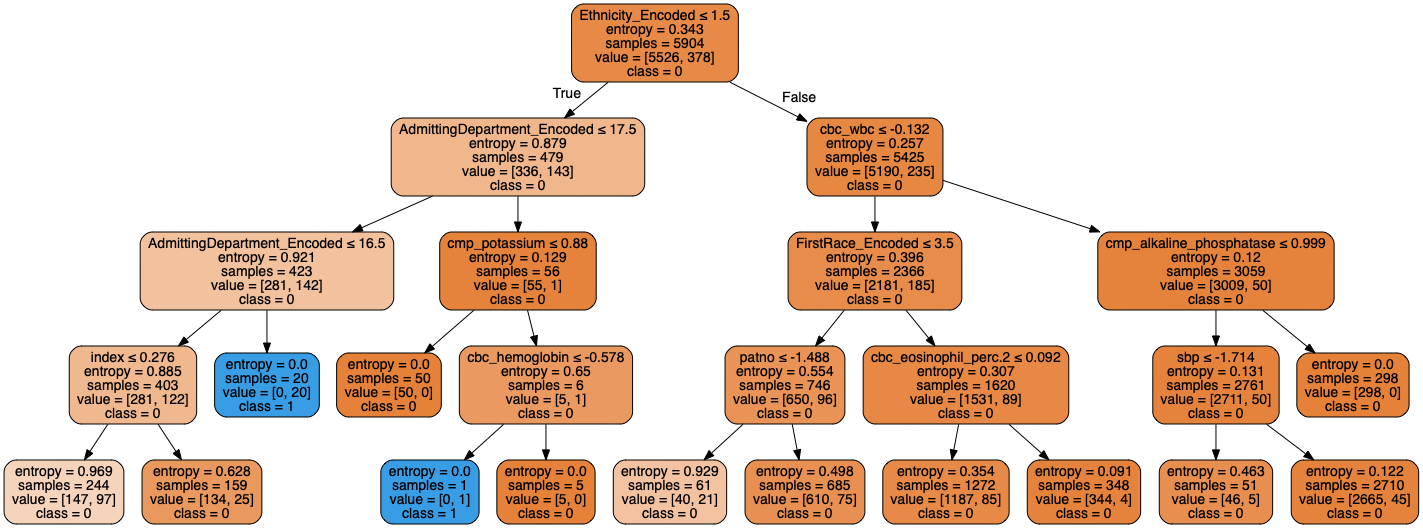

In [61]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=top_n_features, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('rfc.png')
Image(graph.create_png())

###### 4.3.2 Random Forest Classifier <a class="anchor" id="rfc2"></a>

**Metric Scores**

Accuracy: 94.11%
Precision: 100.00%
Recall: 5.43%
F1: 10.31%


**Confusion Matrix**

[[1384    0]
 [  87    5]]


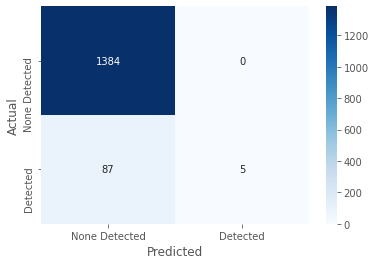

In [62]:
rfc = RandomForestClassifier(
    n_estimators=100, bootstrap=True, max_features='sqrt', random_state=SEED
)
rfc.fit(X_train, y_train)
y_prediction = rfc.predict(X_test)
metric_evaluation(y_test, y_prediction)
plot_confusion_matrix(y_test, y_prediction)

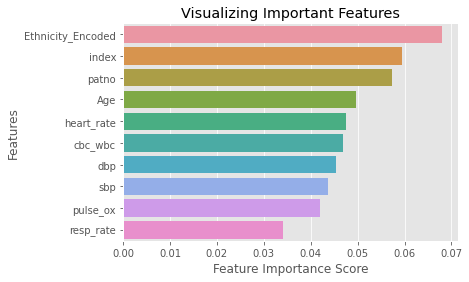

In [63]:
feature_importance = pd.Series(rfc.feature_importances_,index=top_n_features).sort_values(ascending=False).iloc[:10]
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

###### 4.3.3 K-Nearest Neighbors Classifier <a class="anchor" id="knn"></a>

**Metric Scores**

Accuracy: 93.43%
Precision: 42.86%
Recall: 16.30%
F1: 23.62%


**Confusion Matrix**

[[1364   20]
 [  77   15]]


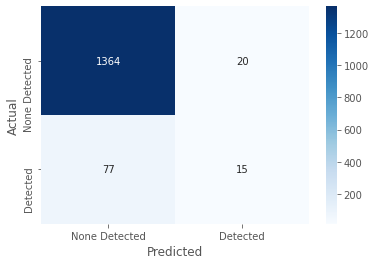

In [135]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_prediction = knn.predict(X_test)
metric_evaluation(y_test, y_prediction)
plot_confusion_matrix(y_test, y_prediction)

###### 4.3.4 Simple Deep Neural Network <a class="anchor" id="dnn"></a>

In [311]:
dnn = Sequential([
    Dense(top_n_feats//2, activation='relu', input_shape=(top_n_feats,)),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='softmax')
])

###### 4.3.5 Convolutional Neural Network <a class="anchor" id="cnn"></a>

In [312]:
cnn = Sequential([
    Conv2D(32, kernel_size=(3, 3), input_shape=(top_n_feats, 1, 1), activation='linear', padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='linear',padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='linear',padding='same'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Flatten(),
    Dense(128, activation='linear'),
    LeakyReLU(alpha=0.1),
    Dense(2, activation='softmax')
])

###### 4.3.6 Recurrent Neural Network <a class="anchor" id="rnn"></a>

In [313]:
# rnn = Sequential([
#     SimpleRNN(16, return_sequences=True, input_shape=(top_n_feats, 1)),
#     SimpleRNN(8, return_sequences=True),
#     Dense(2, activation='softmax')
# ])
rnn = Sequential([
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(2, activation='softmax')
])

#### 4.4 Simultaneous Model Evaluation <a class="anchor" id="eval"></a>

### Model 1 – Deep Neural Network

**Summary**

Model: "sequential_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_411 (Dense)            (None, 20)                820       
_________________________________________________________________
dense_412 (Dense)            (None, 8)                 168       
_________________________________________________________________
dense_413 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_414 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_415 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_416 (Dense)            (None, 2)                 10        
Total params: 1,178
Trainable params: 1,178
Non-trainable params: 0
__________________________________________________

**Training/Validation Loss and Accuracy**

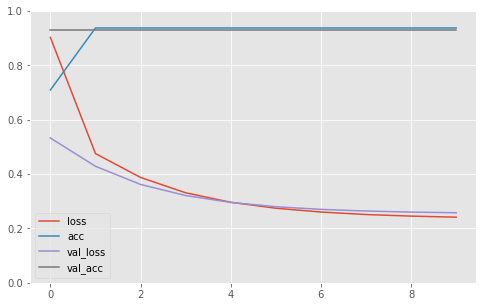

**Evaluation and Prediction**


Loss: 23.96%
Accuracy: 93.77%


**Metric Scores**

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**Confusion Matrix**

[[1384    0]
 [  92    0]]


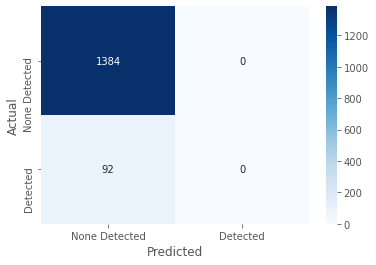

### Model 2 – Convolutional Neural Network

**Summary**

Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_114 (Conv2D)          (None, 40, 1, 32)         320       
_________________________________________________________________
leaky_re_lu_152 (LeakyReLU)  (None, 40, 1, 32)         0         
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 20, 1, 32)         0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 20, 1, 64)         18496     
_________________________________________________________________
leaky_re_lu_153 (LeakyReLU)  (None, 20, 1, 64)         0         
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 10, 1, 64)         0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 10, 1, 128)     

**Training/Validation Loss and Accuracy**

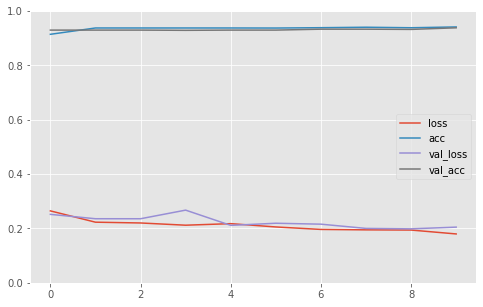

**Evaluation and Prediction**


Loss: 20.31%
Accuracy: 93.90%


**Metric Scores**

Accuracy: 93.90%
Precision: 60.00%
Recall: 6.52%
F1: 11.76%


**Confusion Matrix**

[[1380    4]
 [  86    6]]


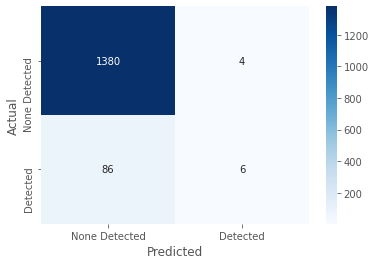

### Model 3 – Recurrent Neural Network

**Summary**

Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                multiple                  16896     
_________________________________________________________________
dense_419 (Dense)            multiple                  130       
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
_________________________________________________________________


**Training/Validation Loss and Accuracy**

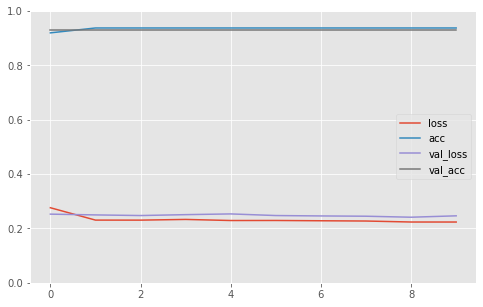

**Evaluation and Prediction**


Loss: 22.41%
Accuracy: 93.77%


**Metric Scores**

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


**Confusion Matrix**

[[1384    0]
 [  92    0]]


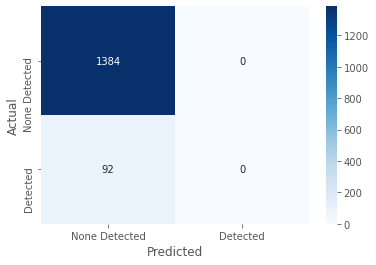


CPU times: user 2min 35s, sys: 29.6 s, total: 3min 5s
Wall time: 1min 28s


In [314]:
%%time
test_models([
    {'name': 'Deep Neural Network', 'model': dnn,
     'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-2),
     'binary': False, 'dims': 2},
    {'name': 'Convolutional Neural Network', 'model': cnn,
     'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-2),
     'binary': False, 'dims': 4},
    {'name': 'Recurrent Neural Network', 'model': rnn,
     'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-2),
     'binary': False, 'dims': 3}
], (X_train, y_train, X_test, y_test))

#### 4.5 Randomized Search <a class="anchor" id="search"></a>

In [70]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[top_n_feats]):
    model = Sequential([
        InputLayer(input_shape=input_shape)
    ])
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1))
    optimizer = SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [71]:
keras_reg = KerasRegressor(build_model)

In [72]:
hyperparameters = {
    'n_hidden': [0, 1, 2, 3],
    'n_neurons': np.arange(1, 100),
    'learning_rate': reciprocal(3e-4, 3e-2)
}

In [73]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)

In [74]:
rnd_search_cv = RandomizedSearchCV(keras_reg, hyperparameters, n_iter=10, cv=cv)

In [75]:
# NOTE: True indicates that the RandomizedSearch should run
#       False indicates that it should not
#       Set to False to avoid ~25 min run time...
run = False

In [76]:
%%time
if run:
    rnd_search_cv.fit(
        X_train, y_train, epochs=EPOCHS, validation_split=VAL_SPLIT, callbacks=[EarlyStopping(patience=10)], verbose=0
    )

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


In [77]:
def rnd_search_results(rscv):
    global final_top_x_models
    
    # 1. Best Model Params
    display(Markdown("**Best Parameters**"))
    best_params = rscv.best_params_
    for k, v in best_params:
        print(k + ":", v)
    print("Best Score: {}".format(rscv.best_score_))
    
    # 2. CV Results
    cv_results = pd.DataFrame(rnd_search_cv.cv_results_)
    print(cv_results)
    
    # 3. Top X
    top_x = 3
    top_x_models = cv_results.loc[cv_results['rank_test_score'].isin(range(1, top_x+1))].sort_values(
        by=['rank_test_score']
    )
    final_top_x_models = top_x_models.reset_index()
    print(final_top_x_models)
    
    # 4. Best!
    print(cv_results.iloc[rnd_search_cv.best_index_])

    
if run:
    rnd_search_results(rnd_search_cv)

In [78]:
def build_model2(n_hidden, n_neurons):
    model = Sequential([
        InputLayer(input_shape=[top_n_feats])
    ])
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1))
    return model

In [79]:
# best_models_list = [{
#     'name': 'Randomized Search: #{} Model'.format(idx + 1),
#     'model': build_model2(n_hidden=model['param_n_hidden'], n_neurons=model['param_n_neurons']),
#     'loss': 'sparse_categorical_crossentropy',
#     'optimizer': SGD(learning_rate=model['param_learning_rate'])
# } for idx, model in final_top_x_models.iterrows()]

In [80]:
# best_models_list

In [81]:
# test_models(best_models_list, (X_train, y_train, X_test, y_test))

## 5. Generative Adverserial Networks (GAN) <a class="anchor" id="gan"></a>

[Table of Contents](#toc)

#### 5.1 Network Setup <a class="anchor" id="setup2"></a>

In [82]:
RAND_DIM = 32
NB_STEPS = 500 + 1
BASE_N_COUNT = 128
BATCH_SIZE = 128
NUM_UPDATES_D = 1         # number of critic network updates per adversarial training step
NUM_UPDATES_G = 1         # number of generator network updates per adversarial training step
NUM_PRE_TRAIN_STEPS = 100 # number of steps to pre-train the critic before starting adversarial training
LOG_INTERVAL = 100        # interval (in steps) at which to log loss summaries and save plots of image samples to disc
LEARNING_RATE = 5e-4 
DIRECTORY = 'GAN/outputs/'
SHOW = True
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

arguments = [
    RAND_DIM, NB_STEPS, BATCH_SIZE, NUM_UPDATES_D, NUM_UPDATES_G, NUM_PRE_TRAIN_STEPS, LOG_INTERVAL,
    LEARNING_RATE, BASE_N_COUNT, DIRECTORY, generator_model_path, discriminator_model_path, loss_pickle_path, SHOW
]

In [83]:
# NOTE: True indicates that the training data will include all real samples
#       False indicates that the training data will include only detected cases
#       Set to False to generate only new detected cases
all_data = False

In [84]:
target = 'COVIDResult_Encoded'
if all_data:
    train = final_data.copy()
else:
    all_detected = final_data.loc[final_data[target] == 1]
    train = all_detected.copy().reset_index(drop=True)

In [85]:
all_columns = list(train.columns.tolist())
data_cols = all_columns[:-1]
label_cols = [target]
train_no_label = train[data_cols] / 10

In [86]:
train.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded
0,-1.728061,-1.728061,0.383537,0.742246,1.413939,0.801611,0.313307,-0.118924,-0.254819,0.928464,...,-0.385608,0.516674,0.724257,-0.209525,0,2.0,1.0,0.0,1.0,1.0
1,-1.723367,-1.723367,0.511066,-0.007125,1.997363,0.974970,-0.607210,0.592883,-0.254819,-0.760847,...,0.037869,0.901837,0.667883,-0.077871,1,9.0,2.0,0.0,30.0,1.0
2,-1.719143,-1.719143,1.488788,-0.215283,-0.303922,0.686038,-0.344205,0.165799,-0.254819,-0.760847,...,-0.287882,0.605558,0.498760,-0.077871,1,9.0,2.0,0.0,30.0,1.0
3,-1.714449,-1.714449,-1.104301,1.241826,-0.401159,-0.007399,-0.475707,2.728304,-0.254819,-0.760847,...,-0.331316,-1.498025,0.329637,-0.143698,1,9.0,2.0,1.0,30.0,1.0
4,-1.698959,-1.698959,0.893653,-0.798127,-1.405946,-1.220915,-1.133219,0.450522,3.495933,1.138256,...,-0.450758,0.546302,0.386011,-0.209525,1,0.0,2.0,0.0,30.0,1.0


#### 5.2 Train GAN Models <a class="anchor" id="train"></a>

In [87]:
gan_model = 'cgan'

###### 5.2.1 GAN <a class="anchor" id="gan2"></a>

In [88]:
%%time
# GAN
if gan_model == 'gan':
    GAN.adversarial_training_GAN(
        arguments=arguments, train=train_no_label, data_cols=data_cols, seed=SEED
    )

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 12.2 µs


###### 5.2.2 CGAN <a class="anchor" id="cgan"></a>

data_dim:  40
data_cols:  ['index', 'patno', 'Age', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin', 'Admitted', 'FirstRace_Encoded', 'Ethnicity_Encoded', 'Sex_Encoded', 'AdmittingDepartment_Encoded']
label_dim:  1
label_cols:  ['COVIDResult_Encoded']
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Model: "generator"
__________________________________________________________________________________________________
Layer (type)           

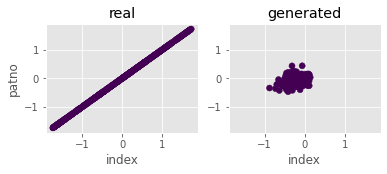

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 7.0954, 0.0071, 0.0645, 1.0000
D Real - D Gen: 0.0574


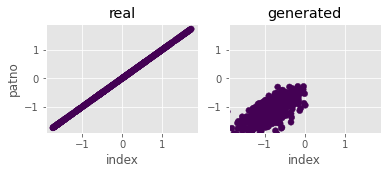

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 4.1956, 0.0720, 0.3638, 1.0000
D Real - D Gen: 0.2918


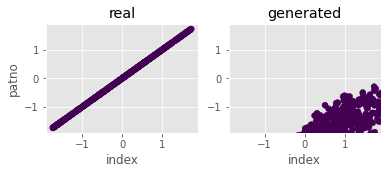

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 4.1077, 0.1984, 0.2486, 0.9872
D Real - D Gen: 0.0502


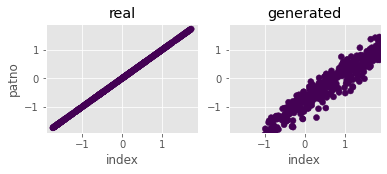

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 2.5642, 0.3440, 0.5211, 0.9957
D Real - D Gen: 0.1771


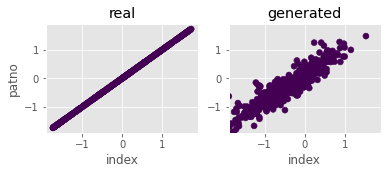

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 2.9273, 0.2250, 0.4844, 0.9830
D Real - D Gen: 0.2594


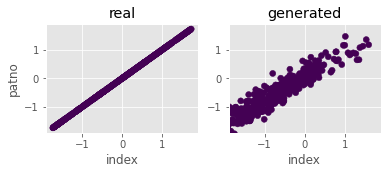

CPU times: user 1min 6s, sys: 3.33 s, total: 1min 9s
Wall time: 23.5 s


In [89]:
%%time
# CGAN
if gan_model == 'cgan':
    GAN.adversarial_training_GAN(
        arguments=arguments, train=train, data_cols=data_cols, label_cols=label_cols, seed=SEED
    )

###### 5.2.3 WGAN and WCGAN <a class="anchor" id="wgan"></a>

In [90]:
# %%time
# # WGAN
# GAN.adversarial_training_WGAN(
#     arguments=arguments, train=train_no_label, data_cols=data_cols, seed=SEED
# )
# # WCGAN
# GAN.adversarial_training_WGAN(
#     arguments=arguments, train=train, data_cols=data_cols, label_cols=label_cols, seed=SEED
# )

#### 5.3 Loss Information <a class="anchor" id="loss"></a>

CPU times: user 267 ms, sys: 15.3 ms, total: 282 ms
Wall time: 286 ms


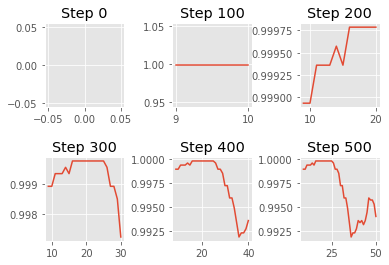

In [91]:
%%time
TYPE_ = 'CGAN'

fig = plt.figure()
fig.subplots_adjust(hspace=0.6, wspace=0.6)
for i, step in zip(range(1, 7), range(0, 600, 100)):
    [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
        open('{}{}_losses_step_{}.pkl'.format(DIRECTORY, TYPE_, step), 'rb')
    )
    
    ax = fig.add_subplot(2, 3, i)
    ax.plot(pd.DataFrame(xgb_losses).rolling(10).mean())
    ax.title.set_text('Step {}'.format(step))

#### 5.4 Generate New Data <a class="anchor" id="new_data"></a>

In [92]:
np.random.seed(SEED)
NEW = 6000  # NOTE: Set to roughly balance the dataset between normal and detected cases
DATA_DIM = len(data_cols)
LABEL_DIM = len(label_cols)
WITH_CLASS = True if LABEL_DIM > 0 else False

In [93]:
def generate_helper(size, generator):
    x = GAN.get_data_batch(train, size, seed=SEED)
    labels = x[:, -LABEL_DIM:]
    
    if all_data: 
        z = np.random.normal(size=(size, RAND_DIM))
        g_z = generator.predict([z, labels]) if WITH_CLASS else generator.predict(z)
    else:
        for _ in range(NEW//size):
            new_z = np.random.normal(size=(size, RAND_DIM))
            new_g_z = generator.predict([new_z, labels]) if WITH_CLASS else generator.predict(new_z)
            try:
                g_z = np.append(g_z, new_g_z, axis=0)
            except:
                g_z = new_g_z
    
    return np.array(x), np.array(g_z)

Accuracy: 0.9973813420621931


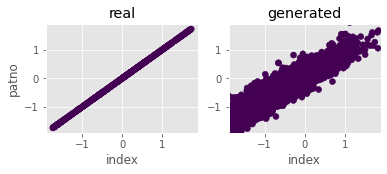

In [94]:
def generate():  
    # 1. Define Models
    generator, discriminator, combined = GAN.define_models_CGAN(
        RAND_DIM, DATA_DIM, LABEL_DIM, BASE_N_COUNT
    )
    generator.load_weights('GAN/outputs/CGAN_generator_model_weights_step_500.h5')
    
    # 2. Generate Batches of Data
    test_size = len(train)
    x, g_z = generate_helper(test_size, generator)
        
    # 3. Visualize Accuracy + New Data
    print("Accuracy:", GAN.CheckAccuracy(
        x, g_z, data_cols, label_cols, seed=SEED, with_class=WITH_CLASS, data_dim=DATA_DIM
    ))
    GAN.PlotData(
        x, g_z, data_cols, label_cols, seed=SEED, with_class=WITH_CLASS, data_dim=DATA_DIM
    )
    return x, g_z
    
batch, generated = generate()

#### 5.5 Test New Data on Models <a class="anchor" id="train_gan"></a>

In [95]:
real = pd.DataFrame(batch, columns=data_cols+label_cols)
real['syn_label'] = 0
real.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded,syn_label
0,0.394523,0.394523,0.936163,0.575719,-0.174272,-0.874197,0.181805,-0.403647,-0.254819,-0.760847,...,-1.498025,-1.587089,-0.407007,0.0,5.0,1.0,0.0,1.0,1.0,0
1,-0.019010,-0.019010,-0.041559,-0.090388,0.603627,0.108173,0.313307,-0.403647,-0.254819,-0.760847,...,-1.498025,-1.587089,-0.407007,0.0,0.0,2.0,0.0,1.0,1.0,0
2,-1.614938,-1.614938,-0.721714,-0.589969,-0.012210,-0.585264,0.313307,-0.546008,-0.254819,1.302216,...,0.872209,1.006128,-0.209525,0.0,0.0,2.0,1.0,1.0,1.0,0
3,1.124425,1.124425,-0.721714,-0.256915,-0.660459,-0.122972,0.444810,-0.118924,-0.254819,-0.760847,...,0.575930,0.498760,-0.077871,0.0,9.0,2.0,0.0,1.0,1.0,0
4,0.020888,0.020888,0.468557,0.242665,-0.271509,0.743825,-0.081200,0.450522,-0.254819,1.238310,...,0.901837,0.216888,0.382920,1.0,0.0,2.0,1.0,17.0,1.0,0


In [96]:
test = pd.DataFrame(generated, columns=data_cols+label_cols)
test['syn_label'] = 1
test.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded,syn_label
0,0.325919,0.089675,0.765508,-0.576044,-0.278467,-0.527982,-0.023833,-1.479397,0.299815,-0.473690,...,-1.342935,-1.157080,-0.403097,-0.099553,7.588366,1.841996,0.493580,-0.133452,1.0,1
1,-0.806098,-0.821781,0.046263,0.393643,-0.281577,-0.916234,0.211689,0.563647,-0.781507,-1.460459,...,0.927454,1.640758,0.136986,-0.375099,-0.824966,2.336936,0.344948,0.686919,1.0,1
2,-0.666667,-0.627893,-0.577045,-0.052837,1.351172,-0.108745,0.059935,0.563618,0.229799,1.178614,...,-1.853202,-1.412222,-0.226527,0.850651,2.481549,2.177228,0.488869,1.370837,1.0,1
3,-2.691964,-2.507712,0.299787,0.562366,0.876796,0.019932,-0.601978,0.854672,-0.657720,0.006655,...,-0.786577,-0.476514,0.161052,0.898395,1.688793,1.360742,0.142445,2.197030,1.0,1
4,-0.349267,-0.557070,-0.130908,1.249737,-0.818304,-1.627146,0.790309,0.232728,-1.207332,-3.344113,...,0.979921,2.209335,0.281804,-0.351504,-0.755420,3.411570,0.635353,-0.013405,1.0,1


In [97]:
real.shape

(470, 42)

In [98]:
test.shape

(5640, 42)

In [99]:
# NOTE: Even split between real and generated data points
SPLIT = 0.5

In [100]:
n_real, n_test = int(len(real)*SPLIT), int(len(test)*SPLIT)

In [101]:
train_gan = pd.concat([real[:n_real], test[:n_test]], axis=0)
train_gan = train_gan.sample(frac=1).reset_index(drop=True) # shuffle
test_gan = pd.concat([real[n_real:], test[n_test:]], axis=0)
test_gan = test_gan.sample(frac=1).reset_index(drop=True) # shuffle

In [102]:
X = train_gan.columns[:-2]
y = train_gan.columns[-1]
y_true = test_gan[y]
d_train = xgb.DMatrix(train_gan[X], train_gan[y], feature_names=X)
d_test = xgb.DMatrix(test_gan[X], feature_names=X)

In [103]:
parameters = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': SEED,
    'eval_metric': 'auc'
}
xgb_clf = xgb.train(parameters, d_train, num_boost_round=10)

**Metric Scores**

Accuracy: 99.74%
Precision: 100.00%
Recall: 99.72%
F1: 99.86%


**Confusion Matrix**

[[ 227    0]
 [   8 2820]]


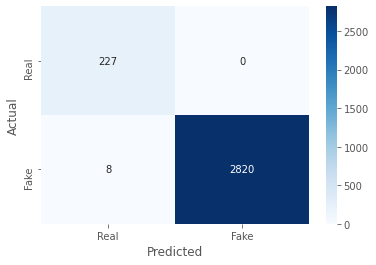

In [104]:
y_pred = xgb_clf.predict(d_test)
metric_evaluation(np.round(y_pred), y_true)
plot_confusion_matrix(np.round(y_pred), y_true, labels=['Real', 'Fake'])

#### 5.6 Plot Real vs Test Data <a class="anchor" id="plot"></a>

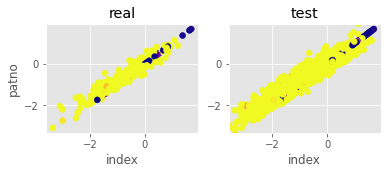

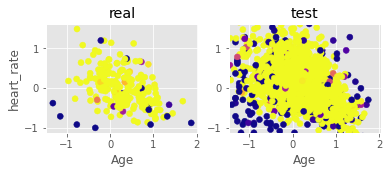

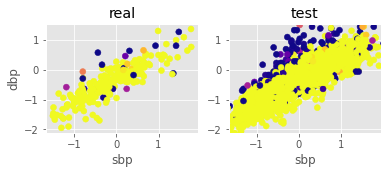

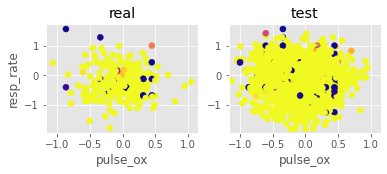

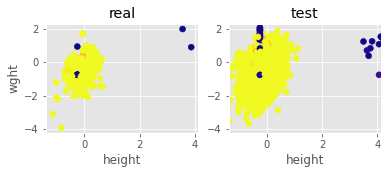

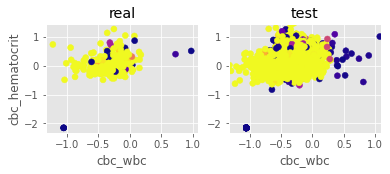

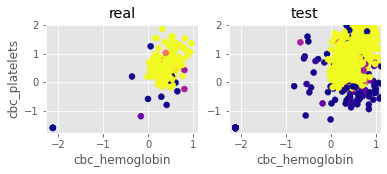

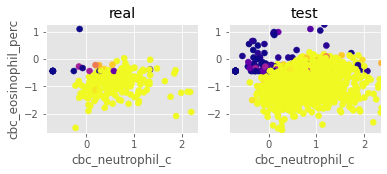

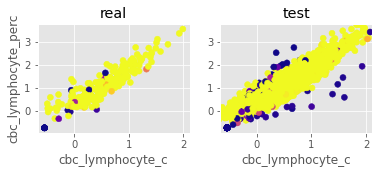

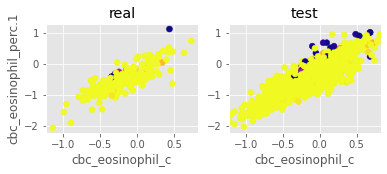

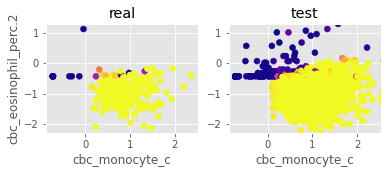

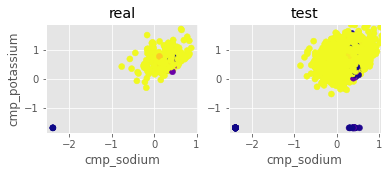

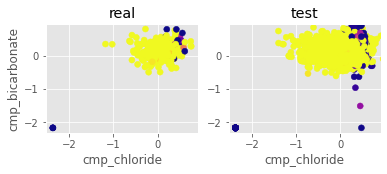

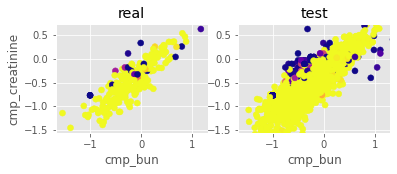

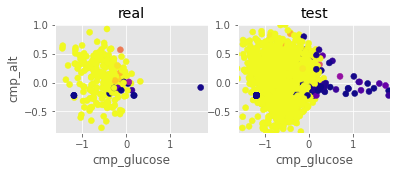

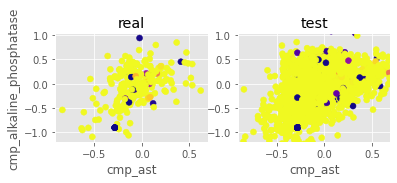

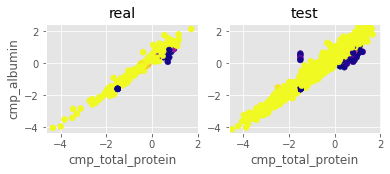

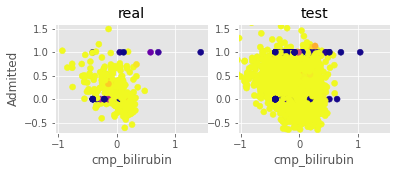

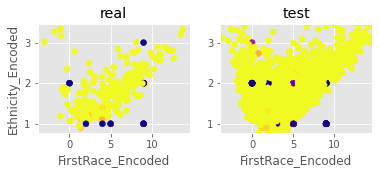

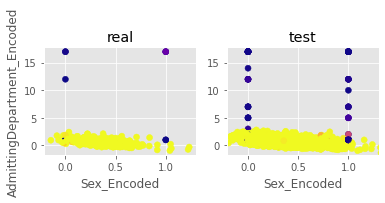

In [105]:
for i in range(0, len(X)-1, 2):
    fig, ax = plt.subplots(1, 2, figsize=(6,2))

    ax[0].scatter(test_gan[:n_real][X[i]], test_gan[:n_real][X[i + 1]], c=y_pred[:n_real], cmap='plasma')
    ax[0].set_title('real')
    ax[0].set_ylabel(X[i + 1])

    ax[1].scatter(test_gan[n_real:][X[i]], test_gan[n_real:][X[i + 1]], c=y_pred[n_real:], cmap='plasma')
    ax[1].set_title('test')
    ax[1].set_xlim(ax[0].get_xlim()), ax[1].set_ylim(ax[0].get_ylim())

    for a in ax:
        a.set_xlabel(X[i])

    plt.show()

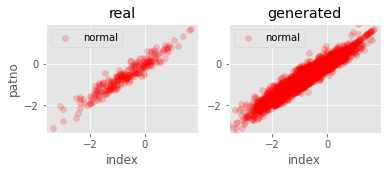

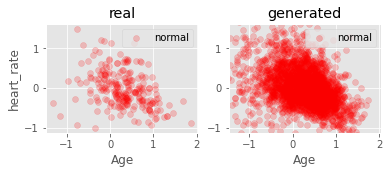

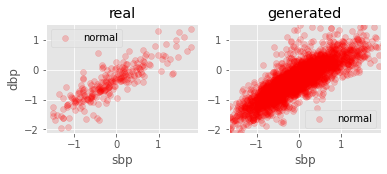

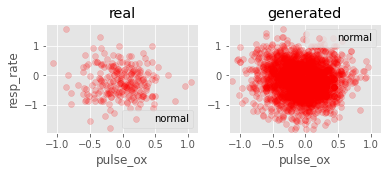

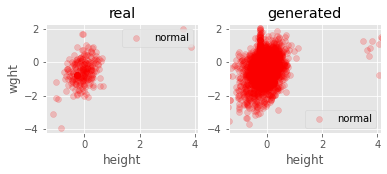

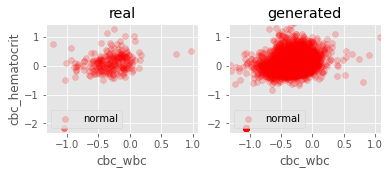

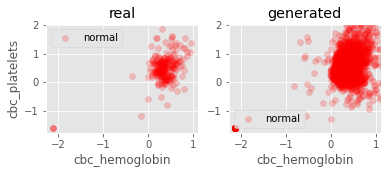

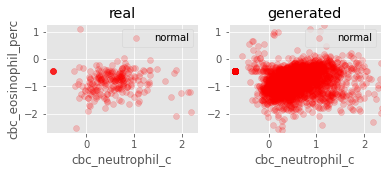

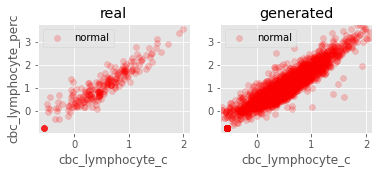

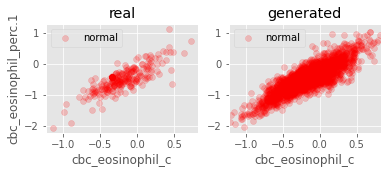

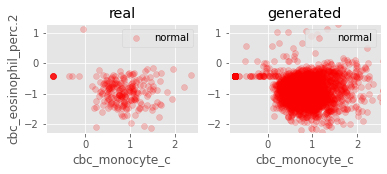

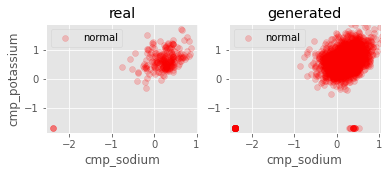

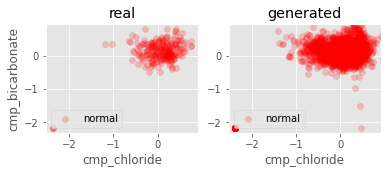

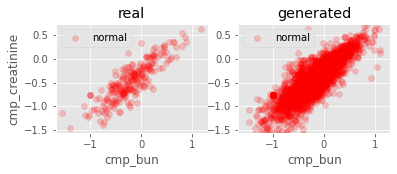

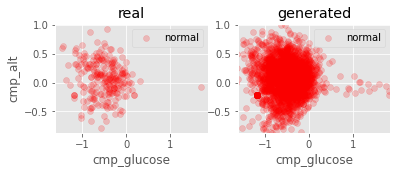

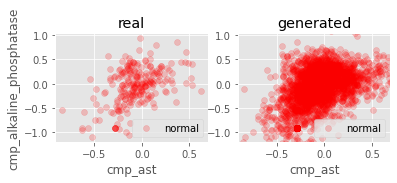

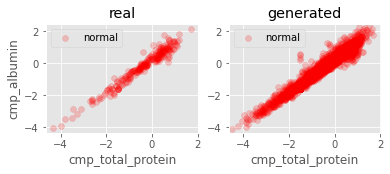

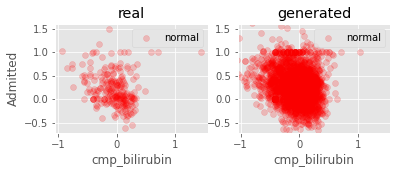

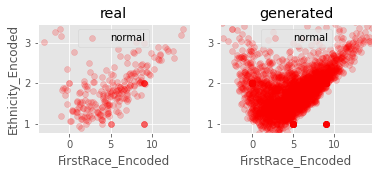

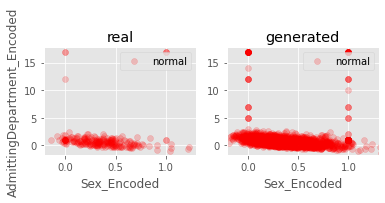

In [106]:
colors = ['red','blue']
markers = ['o','^']
labels = ['normal','detected']

target = 'COVIDResult_Encoded'

for i in range(0, len(X), 2):
    col1, col2 = i, i + 1
    if col2 >= len(X):
        continue
    
    fig, ax = plt.subplots(1, 2, figsize=(6,2))
    for group, color, marker, label in zip( test_gan[:n_real].groupby(target), colors, markers, labels):
        ax[0].scatter( group[1][X[col1]], group[1][X[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    ax[0].legend()
    ax[0].set_title('real')
    ax[0].set_ylabel(X[col2])

    for group, color, marker, label in zip( test_gan[n_real:].groupby(target), colors, markers, labels):
        ax[1].scatter(group[1][X[col1]], group[1][X[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    ax[1].set_xlim(ax[0].get_xlim()), ax[1].set_ylim(ax[0].get_ylim())
    ax[1].legend()
    ax[1].set_title('generated')

    for a in ax:
        a.set_xlabel(X[col1])

    plt.show()

#### 5.7 Feature Importance <a class="anchor" id="importance"></a>

In [107]:
MAX_FEATURES = 20

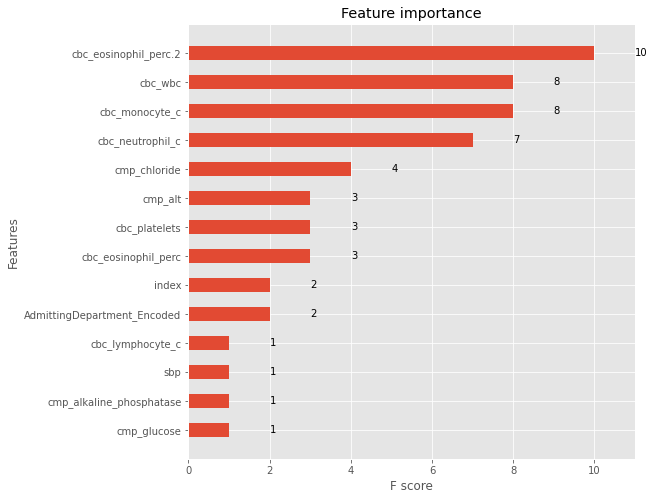

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_clf, max_num_features=MAX_FEATURES, height=0.5, ax=ax)
plt.show()

## 6. Retrain Models with GAN Data <a class="anchor" id="retrain"></a>

[Table of Contents](#toc)

#### 6.1 Re-Prepare Data <a class="anchor" id="prep2"></a>

In [109]:
real_data = final_data.copy()
fake_data = test.copy().drop(columns=['syn_label'])

In [110]:
combined = pd.concat([real_data, fake_data], axis=0)
combined = combined.sample(frac=1).reset_index(drop=True) # shuffle

In [111]:
combined.shape

(13020, 41)

In [112]:
retrain, retest = train_test_split(combined, test_size=0.5, random_state=SEED)

In [113]:
target = 'COVIDResult_Encoded'
X_cols = combined.columns.tolist()
X_cols.remove(target)

In [114]:
X_retrain = retrain[X_cols]
y_retrain = retrain[target]
X_retest = retest[X_cols]
y_retest = retest[target]

#### 6.2 Re-Train Models <a class="anchor" id="retrain2"></a>

**Metric Scores**

Accuracy: 96.05%
Precision: 100.00%
Recall: 91.69%
F1: 95.67%


**Confusion Matrix**

[[3416    0]
 [ 257 2837]]


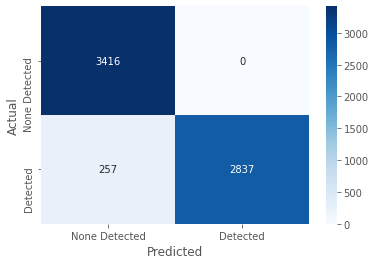

In [115]:
dt = DecisionTreeClassifier(
    max_depth=4, criterion="entropy", random_state=SEED
)
dt = dt.fit(X_retrain, y_retrain)
y_prediction = dt.predict(X_retest)
metric_evaluation(y_retest, y_prediction)
plot_confusion_matrix(y_retest, y_prediction)

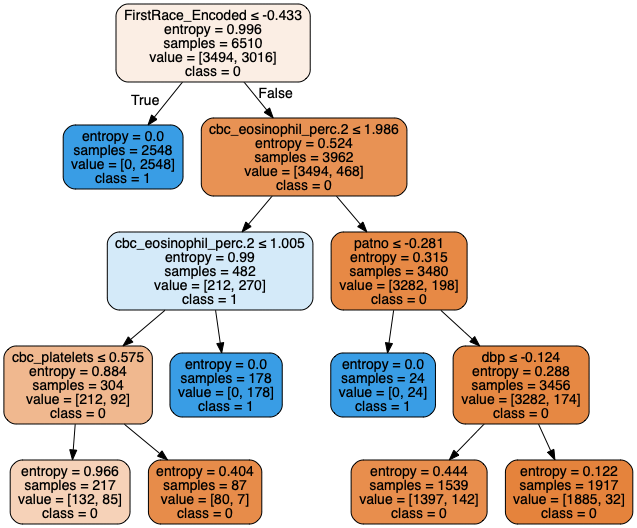

In [116]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=top_n_features, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('rfc.png')
Image(graph.create_png())

**Metric Scores**

Accuracy: 96.64%
Precision: 99.72%
Recall: 93.18%
F1: 96.34%


**Confusion Matrix**

[[3408    8]
 [ 211 2883]]


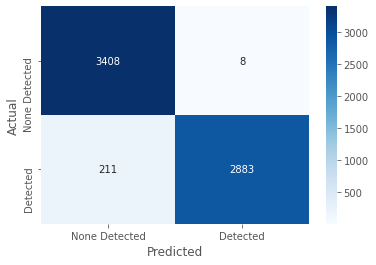

In [117]:
rfc = RandomForestClassifier(
    n_estimators=100, bootstrap=True, max_features='sqrt', random_state=SEED
)
rfc.fit(X_retrain, y_retrain)
y_prediction = rfc.predict(X_retest)
metric_evaluation(y_retest, y_prediction)
plot_confusion_matrix(y_retest, y_prediction)

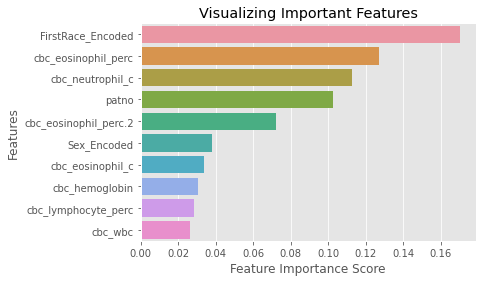

In [118]:
feature_importance = pd.Series(rfc.feature_importances_,index=top_n_features).sort_values(ascending=False).iloc[:10]
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

**Metric Scores**

Accuracy: 96.10%
Precision: 97.40%
Recall: 94.31%
F1: 95.83%


**Confusion Matrix**

[[3338   78]
 [ 176 2918]]


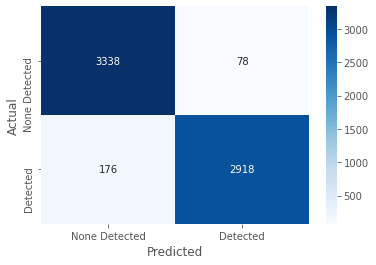

In [146]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_retrain, y_retrain)
y_prediction = knn.predict(X_retest)
metric_evaluation(y_retest, y_prediction)
plot_confusion_matrix(y_retest, y_prediction)

### Model 1 – Deep Neural Network

**Summary**

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_168 (Dense)            (None, 20)                820       
_________________________________________________________________
dense_169 (Dense)            (None, 8)                 168       
_________________________________________________________________
dense_170 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_171 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_172 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_173 (Dense)            (None, 2)                 10        
Total params: 1,178
Trainable params: 1,178
Non-trainable params: 0
___________________________________________________

**Training/Validation Loss and Accuracy**

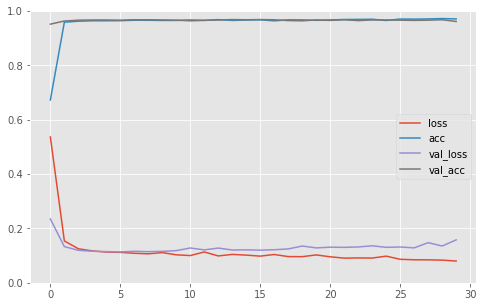

**Evaluation and Prediction**


Loss: 15.27%
Accuracy: 95.99%


**Metric Scores**

Accuracy: 95.99%
Precision: 97.20%
Recall: 94.28%
F1: 95.72%


**Confusion Matrix**

[[3332   84]
 [ 177 2917]]


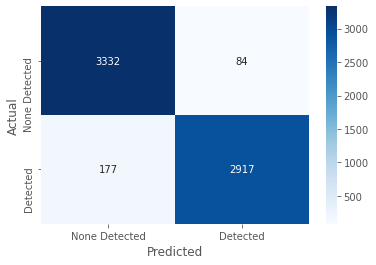

### Model 2 – Convolutional Neural Network

**Summary**

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 40, 1, 32)         320       
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 40, 1, 32)         0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 20, 1, 32)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 20, 1, 64)         18496     
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 20, 1, 64)         0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 10, 1, 64)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 10, 1, 128)      

**Training/Validation Loss and Accuracy**

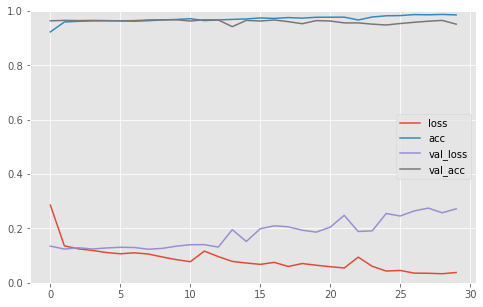

**Evaluation and Prediction**


Loss: 25.07%
Accuracy: 95.35%


**Metric Scores**

Accuracy: 95.35%
Precision: 96.50%
Recall: 93.60%
F1: 95.03%


**Confusion Matrix**

[[3311  105]
 [ 198 2896]]


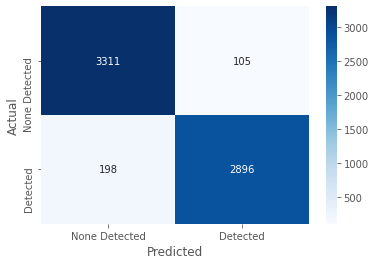

In [228]:
# test_models([
#     {'name': 'Deep Neural Network', 'model': dnn,
#      'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-2), 'binary': False},
#     {'name': 'Convolutional Neural Network', 'model': cnn,
#      'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-2), 'binary': False},
#     {'name': 'Recurrent Neural Network', 'model': rnn,
#      'loss': 'sparse_categorical_crossentropy', 'optimizer': SGD(learning_rate=1e-2), 'binary': False}
# ], (X_retrain, y_retrain, X_retest, y_retest))

## 7. Final Model Training with Feature Selection <a class="anchor" id="final"></a>

[Table of Contents](#toc)

#### 7.1 Define Models and Variables <a class="anchor" id="define"></a>

In [325]:
models = [
    DecisionTreeClassifier(max_depth=4, criterion="entropy", random_state=SEED),
    RandomForestClassifier(n_estimators=100, bootstrap=True, max_features='sqrt', random_state=SEED),
    KNeighborsClassifier(n_neighbors=3),
    'Sequential',
    'Sequential',
    'Sequential'
]
names = [
    'Decision Tree Classifier',
    'Random Forest Classifier',
    'K-Nearest Neighbors Classifier',
    'Deep Neural Network',
    'Convolutional Neural Network',
    'Recurrent Neural Network'
]

In [326]:
for model in models:
    print(model)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=No

In [150]:
# NOTE: Order in which features are dropped, makes function run each model 5 times (len(drops)) 
drops = [
    ('sbp', 'dbp'),
    'pulse_ox',
    'cmp_glucose',
    'resp_rate',
    None
]

In [151]:
metrics = [
    'Accuracy',
    'Precision',
    'Recall',
    'F1'
]

In [327]:
EPOCHS = 10
BATCH_SIZE = 200
VAL_SPLIT = 0.2

In [328]:
def get_neural_net(num_cols, mName):
    m = {
        'Deep Neural Network':
        Sequential([
            Dense(num_cols//2, activation='relu', input_shape=(num_cols,)),
            Dense(8, activation='relu'),
            Dense(8, activation='relu'),
            Dense(8, activation='relu'),
            Dense(4, activation='relu'),
            Dense(2, activation='softmax')
        ]),
        'Convolutional Neural Network':
        Sequential([
            Conv2D(32, kernel_size=(3, 3), input_shape=(num_cols, 1, 1), activation='linear', padding='same'),
            LeakyReLU(alpha=0.1),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(64, (3, 3), activation='linear',padding='same'),
            LeakyReLU(alpha=0.1),
            MaxPooling2D(pool_size=(2, 2), padding='same'),
            Conv2D(128, (3, 3), activation='linear',padding='same'),
            LeakyReLU(alpha=0.1),
            MaxPooling2D(pool_size=(2, 2), padding='same'),
            Flatten(),
            Dense(128, activation='linear'),
            LeakyReLU(alpha=0.1),
            Dense(2, activation='softmax')
        ]),
        'Recurrent Neural Network':
        Sequential([
            LSTM(64, dropout=0.2, recurrent_dropout=0.2),
            Dense(2, activation='softmax')
        ])
    }.get(mName)
    d = {
        'Deep Neural Network': 2,
        'Convolutional Neural Network': 4,
        'Recurrent Neural Network': 3
    }.get(mName)
    
    return m, d

In [318]:
def metric_evaluation2(y_test, y_pred):
    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    prec = round(precision_score(y_test, y_pred) * 100, 2)
    rec = round(recall_score(y_test, y_pred) * 100, 2)
    f1 = round(f1_score(y_test, y_pred) * 100, 2)
    return [acc, prec, rec, f1]

In [339]:
def test_final_models(models_lst, xy):
    X_train, y_train, X_test, y_test = xy
    X_cols = [
        'Age',
        'FirstRace_Encoded',
        'Ethnicity_Encoded',
        'Sex_Encoded',
        'height',
        'wght',
        'heart_rate',
        'sbp',
        'dbp',
        'pulse_ox',
        'resp_rate',
        'cmp_glucose'
    ]
    
    metric_scores_lst = []
    index_tuples = []
    
    for num, drop in enumerate(drops):
        display(Markdown('#### {} Features'.format(len(X_cols))))
        metric_scores = []
        
        for model, name in zip(models_lst, names):
            display(Markdown('<u>{}</u>'.format(name)))
            
            # NOTE: Necessary to account for dynamic input shape and extra compile step
            if model == 'Sequential':
                nn = True
                model, dims = get_neural_net(len(X_cols), name)
                model.compile(
                    loss='sparse_categorical_crossentropy',
                    optimizer=Adam(learning_rate=1e-2),
                    metrics=['accuracy']
                )
                
                X_train_arr = np.array(X_train[X_cols])
                shape = X_train_arr.shape
                if dims == 3:
                    X_train_arr = X_train_arr.reshape(shape[0], shape[1], 1)
                elif dims == 4:
                    X_train_arr = X_train_arr.reshape(shape[0], shape[1], 1, 1)
                
                model.fit(
                    X_train_arr, np.array(y_train),
                    batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT, shuffle=True, verbose=0
                )

            else:
                nn = False
                dims = 2
                model.fit(X_train[X_cols], y_train)
            
            X_test_arr = np.array(X_test[X_cols])
            shape = X_test_arr.shape
            if dims == 3:
                X_test_arr = X_test_arr.reshape(shape[0], shape[1], 1)
            elif dims == 4:
                X_test_arr = X_test_arr.reshape(shape[0], shape[1], 1, 1)
            
            y_prediction = model.predict(X_test_arr)
            y_prediction = np.argmax(y_prediction, axis=1) if nn else np.round(y_prediction)
            metric_evaluation(y_test, y_prediction, labels=False)
            
            metric_scores.extend(metric_evaluation2(y_test, y_prediction))
            if num == 0:
                for metric in metrics:
                    index_tuples.append((name, metric))
        
        metric_scores_lst.append(metric_scores)
        
        if drop is not None:
            if not isinstance(drop, str):
                X_cols.remove(drop[0])
                display(Markdown('*Dropping {}...*'.format(drop[0])))
                X_cols.remove(drop[1])
                display(Markdown('*Dropping {}...*'.format(drop[1])))
                
            else:
                X_cols.remove(drop)
                display(Markdown('*Dropping {}...*'.format(drop)))
           
    index = pd.MultiIndex.from_tuples(index_tuples, names=['Classifier', 'Scores'])
    transposed = map(list, zip(*metric_scores_lst))
    return pd.DataFrame(transposed, columns=['12', '10', '9', '8', '7'], index=index)

#### 7.2 Model Performance without GAN (Real Data) <a class="anchor" id="perf1"></a>

In [338]:
%%time
metric_df1 = test_final_models(models, (X_train, y_train, X_test, y_test))

#### 12 Features

<u>Decision Tree Classifier</u>

Accuracy: 93.70%
Precision: 46.67%
Recall: 7.61%
F1: 13.08%
[[1376    8]
 [  85    7]]


<u>Random Forest Classifier</u>

Accuracy: 94.11%
Precision: 77.78%
Recall: 7.61%
F1: 13.86%
[[1382    2]
 [  85    7]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 92.89%
Precision: 29.03%
Recall: 9.78%
F1: 14.63%
[[1362   22]
 [  83    9]]


<u>Deep Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<u>Convolutional Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


<u>Recurrent Neural Network</u>

ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: target=4271    0.0
1095    0.0
3538    0.0
2377    0.0
3414    0.0
       ... 
4931    0.0
3264    0.0
1653    0.0
2607    0.0
2732    0.0
Name: COVIDResult_Encoded, Length: 5904, dtype: float64

In [336]:
metric_df1

12     10      9      8      7
Classifier                     Scores                                      
Decision Tree Classifier       Accuracy   93.70  93.70  93.77  93.77  93.77
                               Precision  46.67  46.67   0.00  50.00  50.00
                               Recall      7.61   7.61   0.00   3.26   3.26
                               F1         13.08  13.08   0.00   6.12   6.12
Random Forest Classifier       Accuracy   94.11  93.97  93.56  93.56  93.16
                               Precision  77.78  61.54  42.11  40.00  28.57
                               Recall      7.61   8.70   8.70   6.52   6.52
                               F1         13.86  15.24  14.41  11.21  10.62
K-Nearest Neighbors Classifier Accuracy   92.89  92.68  93.09  92.07  93.02
                               Precision  29.03  26.47  34.38  12.12  29.63
                               Recall      9.78   9.78  11.96   4.35   8.70
                               F1         14.63  14.29  17.74   6.40  13.45
Deep Neural Network            Accuracy   93.77  93.77  93.77  93.77  93.77
                               Precision   0.00   0.00   0.00   0.00   0.00
                               Recall      0.00   0.00   0.00   0.00   0.00
                               F1          0.00   0.00   0.00   0.00   0.00
Convolutional Neural Network   Accuracy   93.77  93.77  93.77  93.77  93.77
                               Precision   0.00   0.00   0.00   0.00   0.00
                               Recall      0.00   0.00   0.00   0.00   0.00
                               F1          0.00   0.00   0.00   0.00   0.00
Recurrent Neural Network       Accuracy   93.77  93.77  93.77  93.77  93.77
                               Precision   0.00   0.00   0.00   0.00   0.00
                               Recall      0.00   0.00   0.00   0.00   0.00
                               F1          0.00   0.00   0.00   0.00   0.00

#### 7.3 Model Performance with GAN <a class="anchor" id="perf2"></a>

In [340]:
%%time
metric_df2 = test_final_models(models, (X_retrain, y_retrain, X_retest, y_retest))

#### 12 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.34%
Precision: 99.86%
Recall: 92.44%
F1: 96.01%
[[3412    4]
 [ 234 2860]]


<u>Random Forest Classifier</u>

Accuracy: 96.45%
Precision: 99.76%
Recall: 92.76%
F1: 96.13%
[[3409    7]
 [ 224 2870]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 95.05%
Precision: 95.86%
Recall: 93.63%
F1: 94.74%
[[3291  125]
 [ 197 2897]]


<u>Deep Neural Network</u>

Accuracy: 94.56%
Precision: 97.50%
Recall: 90.89%
F1: 94.08%
[[3344   72]
 [ 282 2812]]


<u>Convolutional Neural Network</u>

Accuracy: 95.76%
Precision: 98.39%
Recall: 92.60%
F1: 95.40%
[[3369   47]
 [ 229 2865]]


<u>Recurrent Neural Network</u>

Accuracy: 89.19%
Precision: 86.23%
Recall: 91.92%
F1: 88.99%
[[2962  454]
 [ 250 2844]]


*Dropping sbp...*

*Dropping dbp...*

#### 10 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.34%
Precision: 99.86%
Recall: 92.44%
F1: 96.01%
[[3412    4]
 [ 234 2860]]


<u>Random Forest Classifier</u>

Accuracy: 96.39%
Precision: 99.34%
Recall: 93.02%
F1: 96.08%
[[3397   19]
 [ 216 2878]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 95.13%
Precision: 96.36%
Recall: 93.28%
F1: 94.79%
[[3307  109]
 [ 208 2886]]


<u>Deep Neural Network</u>

Accuracy: 52.47%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[3416    0]
 [3094    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<u>Convolutional Neural Network</u>

Accuracy: 95.82%
Precision: 98.55%
Recall: 92.57%
F1: 95.47%
[[3374   42]
 [ 230 2864]]


<u>Recurrent Neural Network</u>

Accuracy: 94.76%
Precision: 97.94%
Recall: 90.89%
F1: 94.28%
[[3357   59]
 [ 282 2812]]


*Dropping pulse_ox...*

#### 9 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.37%
Precision: 99.86%
Recall: 92.50%
F1: 96.04%
[[3412    4]
 [ 232 2862]]


<u>Random Forest Classifier</u>

Accuracy: 96.27%
Precision: 99.21%
Recall: 92.89%
F1: 95.94%
[[3393   23]
 [ 220 2874]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 95.19%
Precision: 96.46%
Recall: 93.31%
F1: 94.86%
[[3310  106]
 [ 207 2887]]


<u>Deep Neural Network</u>

Accuracy: 92.41%
Precision: 92.43%
Recall: 91.53%
F1: 91.98%
[[3184  232]
 [ 262 2832]]


<u>Convolutional Neural Network</u>

Accuracy: 95.53%
Precision: 98.92%
Recall: 91.60%
F1: 95.12%
[[3385   31]
 [ 260 2834]]


<u>Recurrent Neural Network</u>

Accuracy: 95.10%
Precision: 97.47%
Recall: 92.08%
F1: 94.70%
[[3342   74]
 [ 245 2849]]


*Dropping cmp_glucose...*

#### 8 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.37%
Precision: 99.90%
Recall: 92.47%
F1: 96.04%
[[3413    3]
 [ 233 2861]]


<u>Random Forest Classifier</u>

Accuracy: 96.31%
Precision: 99.21%
Recall: 92.99%
F1: 96.00%
[[3393   23]
 [ 217 2877]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 94.99%
Precision: 95.95%
Recall: 93.41%
F1: 94.66%
[[3294  122]
 [ 204 2890]]


<u>Deep Neural Network</u>

Accuracy: 89.48%
Precision: 86.73%
Recall: 91.92%
F1: 89.25%
[[2981  435]
 [ 250 2844]]


<u>Convolutional Neural Network</u>

Accuracy: 89.45%
Precision: 85.24%
Recall: 94.09%
F1: 89.45%
[[2912  504]
 [ 183 2911]]


<u>Recurrent Neural Network</u>

Accuracy: 94.64%
Precision: 96.99%
Recall: 91.56%
F1: 94.20%
[[3328   88]
 [ 261 2833]]


*Dropping resp_rate...*

#### 7 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.34%
Precision: 99.83%
Recall: 92.47%
F1: 96.01%
[[3411    5]
 [ 233 2861]]


<u>Random Forest Classifier</u>

Accuracy: 95.91%
Precision: 98.36%
Recall: 92.95%
F1: 95.58%
[[3368   48]
 [ 218 2876]]


<u>K-Nearest Neighbors Classifier</u>

Accuracy: 95.12%
Precision: 96.27%
Recall: 93.34%
F1: 94.78%
[[3304  112]
 [ 206 2888]]


<u>Deep Neural Network</u>

Accuracy: 90.17%
Precision: 89.92%
Recall: 89.33%
F1: 89.62%
[[3106  310]
 [ 330 2764]]


<u>Convolutional Neural Network</u>

Accuracy: 94.02%
Precision: 99.96%
Recall: 87.46%
F1: 93.29%
[[3415    1]
 [ 388 2706]]


<u>Recurrent Neural Network</u>

Accuracy: 90.03%
Precision: 86.94%
Recall: 92.99%
F1: 89.86%
[[2984  432]
 [ 217 2877]]
CPU times: user 7min 30s, sys: 50.6 s, total: 8min 21s
Wall time: 5min 42s


In [341]:
metric_df2

12     10      9      8      7
Classifier                     Scores                                      
Decision Tree Classifier       Accuracy   96.34  96.34  96.37  96.37  96.34
                               Precision  99.86  99.86  99.86  99.90  99.83
                               Recall     92.44  92.44  92.50  92.47  92.47
                               F1         96.01  96.01  96.04  96.04  96.01
Random Forest Classifier       Accuracy   96.45  96.39  96.27  96.31  95.91
                               Precision  99.76  99.34  99.21  99.21  98.36
                               Recall     92.76  93.02  92.89  92.99  92.95
                               F1         96.13  96.08  95.94  96.00  95.58
K-Nearest Neighbors Classifier Accuracy   95.05  95.13  95.19  94.99  95.12
                               Precision  95.86  96.36  96.46  95.95  96.27
                               Recall     93.63  93.28  93.31  93.41  93.34
                               F1         94.74  94.79  94.86  94.66  94.78
Deep Neural Network            Accuracy   94.56  52.47  92.41  89.48  90.17
                               Precision  97.50   0.00  92.43  86.73  89.92
                               Recall     90.89   0.00  91.53  91.92  89.33
                               F1         94.08   0.00  91.98  89.25  89.62
Convolutional Neural Network   Accuracy   95.76  95.82  95.53  89.45  94.02
                               Precision  98.39  98.55  98.92  85.24  99.96
                               Recall     92.60  92.57  91.60  94.09  87.46
                               F1         95.40  95.47  95.12  89.45  93.29
Recurrent Neural Network       Accuracy   89.19  94.76  95.10  94.64  90.03
                               Precision  86.23  97.94  97.47  96.99  86.94
                               Recall     91.92  90.89  92.08  91.56  92.99
                               F1         88.99  94.28  94.70  94.20  89.86